<a href="https://colab.research.google.com/github/RyosukeHanaoka/jcr2025/blob/main/swin_transformer_with_mixup_and_various_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install vit_pytorch timm
from __future__ import print_function

import glob
import os
import random
import cv2
import shutil
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.optim import AdamW
from torchvision import transforms

def split_and_move_files(src_dir, train_dest, val_dest, test_dest, split_ratio=(0.6, 0.3, 0.1)):
    all_files = glob.glob(f"{src_dir}/*")
    random.shuffle(all_files)

    train_split = int(split_ratio[0] * len(all_files))
    val_split = train_split + int(split_ratio[1] * len(all_files))

    for idx, file in enumerate(all_files):
        if idx < train_split:
            dest = train_dest
        elif idx < val_split:
            dest = val_dest
        else:
            dest = test_dest
        os.makedirs(dest, exist_ok=True)
        shutil.copy(file, os.path.join(dest, os.path.basename(file)))

src_dir_RA = '/content/drive/MyDrive/image_RA'
train_dest_RA = '/content/train/RA_Right_Hand'
val_dest_RA = '/content/val/RA_Right_Hand'
test_dest_RA = '/content/test/RA_Right_Hand'

split_and_move_files(src_dir_RA, train_dest_RA, val_dest_RA, test_dest_RA)

src_dir_nonRA = '/content/drive/MyDrive/image_nonRA'
train_dest_nonRA = '/content/train/nonRA_Right_Hand'
val_dest_nonRA = '/content/val/nonRA_Right_Hand'
test_dest_nonRA = '/content/test/nonRA_Right_Hand'

split_and_move_files(src_dir_nonRA, train_dest_nonRA, val_dest_nonRA, test_dest_nonRA)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 6.4 MB/s eta 0:00:00


In [20]:
batch_size=96
epochs = 300
lr = 0.08*3e-4
gamma = 0.8
seed = 42
#dropout_of_model('swin_base_patch4_window7_224.ms_in1k')
drop_rate=0.4
attn_drop_rate=0.35
drop_path_rate=0.35
mixup_alpha=0.3
#optimizer's_settings(AdamW)
weight_decay=6e-3
#scheduler's_settings(CosineAnnealingWarmRestarts)
T_0=100
T_mult=2
eta_min=1e-7

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)
device = 'cuda'

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=8),
    transforms.RandomAffine(degrees=0, translate=(0.08, 0.08)),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.03),
    transforms.RandomPerspective(distortion_scale=0.12, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
from torchvision.datasets import ImageFolder
from PIL import Image, UnidentifiedImageError

train_dir = "/content/train"
val_dir = "/content/val"
test_dir = "/content/test"

class RobustImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super(RobustImageFolder, self).__getitem__(index)
        except UnidentifiedImageError:
            print(f"Couldn't read image at index {index}: UnidentifiedImageError")
            img = Image.new('RGB', (224, 224), color = 'gray')
            img = self.transform(img)
            target = 0
            return img, target

# データセットの定義
train_dataset = RobustImageFolder(train_dir, transform=train_transforms)
valid_dataset = RobustImageFolder(val_dir, transform=val_transforms)
test_dataset = RobustImageFolder(test_dir, transform=test_transforms)

# データローダーの設定を最適化
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

model_names = timm.list_models(pretrained=True)
model = timm.create_model(
    'swin_base_patch4_window7_224.ms_in1k',
    pretrained=True,
    num_classes=2,
    drop_block_rate=None,
    drop_connect_rate=None,
    drop_rate=drop_rate,
    attn_drop_rate=attn_drop_rate,
    drop_path_rate=drop_path_rate,
)
# Google Colabでランタイプ：GPUにしている場合は必要
model.to("cuda:0")
# loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# criterion = nn.HuberLoss()
# optimizer
optimizer = AdamW(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay
)

#scheduler = StepLR(optimizer, step_size=3, gamma=gamma)
scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=T_0,
    T_mult=T_mult,
    eta_min=eta_min
)

学習ループを設定し、実行していく

In [21]:
import gc
from torchvision.utils import make_grid

import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = ':'.join([
    'max_split_size_mb:128',
    'expandable_segments:True'
])

class Mixup:
    def __init__(self, alpha=mixup_alpha):
        self.alpha = alpha

    def __call__(self, batch, target):
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1

        batch_size = len(batch)
        index = torch.randperm(batch_size).to(batch.device)

        mixed_batch = lam * batch + (1 - lam) * batch[index, :]
        target_a, target_b = target, target[index]
        return mixed_batch, target_a, target_b, lam

def train_with_gradient_accumulation(model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs):
    accumulation_steps = 4
    effective_batch_size = batch_size
    actual_batch_size = effective_batch_size // accumulation_steps

    train_acc_list = []
    val_acc_list = []
    test_acc_list = []
    train_loss_list = []
    val_loss_list = []
    test_loss_list = []

    # 新しい指標のリストを追加
    val_sensitivity_list = []
    val_specificity_list = []
    val_f1_list = []
    test_sensitivity_list = []
    test_specificity_list = []
    test_f1_list = []

    scaler = torch.cuda.amp.GradScaler()
    mixup = Mixup(alpha=mixup_alpha)

    def calculate_metrics(outputs, labels):
        predictions = outputs.argmax(dim=1)
        tp = ((predictions == 1) & (labels == 1)).float().sum()
        tn = ((predictions == 0) & (labels == 0)).float().sum()
        fp = ((predictions == 1) & (labels == 0)).float().sum()
        fn = ((predictions == 0) & (labels == 1)).float().sum()

        sensitivity = tp / (tp + fn + 1e-7)
        specificity = tn / (tn + fp + 1e-7)
        precision = tp / (tp + fp + 1e-7)
        f1_score = 2 * (precision * sensitivity) / (precision + sensitivity + 1e-7)

        return sensitivity.item(), specificity.item(), f1_score.item()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_accuracy = 0
        optimizer.zero_grad()

        for i, (data, label) in enumerate(tqdm(train_loader)):
            with torch.cuda.amp.autocast():
                data = data.to(device)
                label = label.to(device)

                mixed_data, labels_a, labels_b, lam = mixup(data, label)

                output = model(mixed_data)
                loss = criterion(output, labels_a) * lam + criterion(output, labels_b) * (1 - lam)
                loss = loss / accumulation_steps

            scaler.scale(loss).backward()

            if ((i + 1) % accumulation_steps == 0) or (i + 1 == len(train_loader)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            acc = (lam * (output.argmax(dim=1) == labels_a).float() +
                  (1 - lam) * (output.argmax(dim=1) == labels_b).float()).mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss * accumulation_steps / len(train_loader)

            del data, label, mixed_data, labels_a, labels_b, output, loss
            if (i + 1) % (accumulation_steps * 2) == 0:
                torch.cuda.empty_cache()

        # 検証フェーズ
        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            val_outputs = []
            val_labels = []

            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                val_outputs.append(val_output)
                val_labels.append(label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

                del data, label, val_output, val_loss

            # 検証データセット全体での指標計算
            val_outputs = torch.cat(val_outputs)
            val_labels = torch.cat(val_labels)
            val_sensitivity, val_specificity, val_f1 = calculate_metrics(val_outputs, val_labels)

            # テストフェーズ
            epoch_test_accuracy = 0
            epoch_test_loss = 0
            test_outputs = []
            test_labels = []

            for data, label in tqdm(test_loader):
                data = data.to(device)
                label = label.to(device)

                test_output = model(data)
                test_loss = criterion(test_output, label)

                test_outputs.append(test_output)
                test_labels.append(label)

                acc = (test_output.argmax(dim=1) == label).float().mean()
                epoch_test_accuracy += acc / len(test_loader)
                epoch_test_loss += test_loss / len(test_loader)

                del data, label, test_output, test_loss

            # テストデータセット全体での指標計算
            test_outputs = torch.cat(test_outputs)
            test_labels = torch.cat(test_labels)
            test_sensitivity, test_specificity, test_f1 = calculate_metrics(test_outputs, test_labels)

            torch.cuda.empty_cache()

        # 結果の記録
        train_acc_list.append(epoch_accuracy)
        val_acc_list.append(epoch_val_accuracy)
        test_acc_list.append(epoch_test_accuracy)
        train_loss_list.append(epoch_loss)
        val_loss_list.append(epoch_val_loss)
        test_loss_list.append(epoch_test_loss)

        # 新しい指標の記録
        val_sensitivity_list.append(val_sensitivity)
        val_specificity_list.append(val_specificity)
        val_f1_list.append(val_f1)
        test_sensitivity_list.append(test_sensitivity)
        test_specificity_list.append(test_specificity)
        test_f1_list.append(test_f1)

        print(
            f"Epoch : {epoch+1} - "
            f"loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - "
            f"val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} - "
            f"val_sensitivity: {val_sensitivity:.4f} - val_specificity: {val_specificity:.4f} - val_f1: {val_f1:.4f} - "
            f"test_loss : {epoch_test_loss:.4f} - test_acc: {epoch_test_accuracy:.4f} - "
            f"test_sensitivity: {test_sensitivity:.4f} - test_specificity: {test_specificity:.4f} - test_f1: {test_f1:.4f}\n"
        )

        scheduler.step()

    return (train_acc_list, val_acc_list, test_acc_list,
            train_loss_list, val_loss_list, test_loss_list,
            val_sensitivity_list, val_specificity_list, val_f1_list,
            test_sensitivity_list, test_specificity_list, test_f1_list)

# モデルの設定を最適化
def optimize_model_settings():
    # メモリ関連の設定を最適化
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True

    # モデルの設定を最適化
    model.to(device)
    if hasattr(model, 'transformer'):
        for block in model.transformer.blocks:
            block.attn.fused_attn = True

    return model

def main():
    model = optimize_model_settings()
    metrics = train_with_gradient_accumulation(
        model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs
    )
    return (model, *metrics)

# 実行
model, train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list, \
    val_sensitivity_list, val_specificity_list, val_f1_list, \
    test_sensitivity_list, test_specificity_list, test_f1_list = main()

<ipython-input-21-66418d666f4d>:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-21-66418d666f4d>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 1 - train_loss : 0.7151 - train_acc: 0.5011 - val_loss : 0.8439 - val_acc: 0.3021 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.7199 - test_acc: 0.5263 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 2 - train_loss : 0.7441 - train_acc: 0.5322 - val_loss : 0.8029 - val_acc: 0.3021 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.7043 - test_acc: 0.5263 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 3 - train_loss : 0.6941 - train_acc: 0.5373 - val_loss : 0.7712 - val_acc: 0.3021 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.6932 - test_acc: 0.5263 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 4 - train_loss : 0.6820 - train_acc: 0.5522 - val_loss : 0.7564 - val_acc: 0.3021 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.6877 - test_acc: 0.5263 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 5 - train_loss : 0.7122 - train_acc: 0.4459 - val_loss : 0.7459 - val_acc: 0.3073 - val_sensitivity: 0.0200 - val_specificity: 1.0000 - val_f1: 0.0392 - test_loss : 0.6837 - test_acc: 0.5263 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 6 - train_loss : 0.6932 - train_acc: 0.5139 - val_loss : 0.7420 - val_acc: 0.3021 - val_sensitivity: 0.0200 - val_specificity: 0.9828 - val_f1: 0.0385 - test_loss : 0.6810 - test_acc: 0.5526 - test_sensitivity: 0.0556 - test_specificity: 1.0000 - test_f1: 0.1053



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 7 - train_loss : 0.6850 - train_acc: 0.5872 - val_loss : 0.7373 - val_acc: 0.3542 - val_sensitivity: 0.0800 - val_specificity: 0.9828 - val_f1: 0.1455 - test_loss : 0.6780 - test_acc: 0.5263 - test_sensitivity: 0.0556 - test_specificity: 0.9500 - test_f1: 0.1000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 8 - train_loss : 0.6781 - train_acc: 0.5802 - val_loss : 0.7251 - val_acc: 0.3594 - val_sensitivity: 0.1400 - val_specificity: 0.9483 - val_f1: 0.2333 - test_loss : 0.6738 - test_acc: 0.5000 - test_sensitivity: 0.1111 - test_specificity: 0.8500 - test_f1: 0.1739



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 9 - train_loss : 0.6716 - train_acc: 0.5858 - val_loss : 0.7154 - val_acc: 0.4427 - val_sensitivity: 0.3200 - val_specificity: 0.9483 - val_f1: 0.4638 - test_loss : 0.6702 - test_acc: 0.5789 - test_sensitivity: 0.3889 - test_specificity: 0.7500 - test_f1: 0.4667



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 10 - train_loss : 0.6629 - train_acc: 0.6129 - val_loss : 0.7028 - val_acc: 0.4479 - val_sensitivity: 0.4000 - val_specificity: 0.8966 - val_f1: 0.5263 - test_loss : 0.6669 - test_acc: 0.6316 - test_sensitivity: 0.5000 - test_specificity: 0.7500 - test_f1: 0.5625



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 11 - train_loss : 0.6716 - train_acc: 0.5416 - val_loss : 0.6974 - val_acc: 0.4948 - val_sensitivity: 0.4600 - val_specificity: 0.8793 - val_f1: 0.5750 - test_loss : 0.6639 - test_acc: 0.6316 - test_sensitivity: 0.5000 - test_specificity: 0.7500 - test_f1: 0.5625



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 12 - train_loss : 0.6584 - train_acc: 0.6456 - val_loss : 0.6920 - val_acc: 0.5312 - val_sensitivity: 0.5000 - val_specificity: 0.8448 - val_f1: 0.5952 - test_loss : 0.6609 - test_acc: 0.6053 - test_sensitivity: 0.5000 - test_specificity: 0.7000 - test_f1: 0.5455



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 13 - train_loss : 0.6505 - train_acc: 0.6602 - val_loss : 0.6882 - val_acc: 0.5208 - val_sensitivity: 0.5200 - val_specificity: 0.7931 - val_f1: 0.5909 - test_loss : 0.6577 - test_acc: 0.6053 - test_sensitivity: 0.5556 - test_specificity: 0.6500 - test_f1: 0.5714



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 14 - train_loss : 0.6842 - train_acc: 0.5444 - val_loss : 0.6790 - val_acc: 0.5052 - val_sensitivity: 0.5400 - val_specificity: 0.7241 - val_f1: 0.5806 - test_loss : 0.6554 - test_acc: 0.6316 - test_sensitivity: 0.6111 - test_specificity: 0.6500 - test_f1: 0.6111



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 15 - train_loss : 0.6439 - train_acc: 0.6728 - val_loss : 0.6691 - val_acc: 0.6354 - val_sensitivity: 0.6400 - val_specificity: 0.7069 - val_f1: 0.6465 - test_loss : 0.6535 - test_acc: 0.6053 - test_sensitivity: 0.6111 - test_specificity: 0.6000 - test_f1: 0.5946



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 16 - train_loss : 0.6454 - train_acc: 0.6371 - val_loss : 0.6631 - val_acc: 0.6406 - val_sensitivity: 0.6800 - val_specificity: 0.6897 - val_f1: 0.6667 - test_loss : 0.6513 - test_acc: 0.6316 - test_sensitivity: 0.6667 - test_specificity: 0.6000 - test_f1: 0.6316



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 17 - train_loss : 0.6446 - train_acc: 0.6439 - val_loss : 0.6534 - val_acc: 0.6406 - val_sensitivity: 0.7800 - val_specificity: 0.6034 - val_f1: 0.6964 - test_loss : 0.6505 - test_acc: 0.6579 - test_sensitivity: 0.7778 - test_specificity: 0.5500 - test_f1: 0.6829



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 18 - train_loss : 0.6357 - train_acc: 0.6408 - val_loss : 0.6500 - val_acc: 0.6406 - val_sensitivity: 0.7800 - val_specificity: 0.6034 - val_f1: 0.6964 - test_loss : 0.6482 - test_acc: 0.6842 - test_sensitivity: 0.8333 - test_specificity: 0.5500 - test_f1: 0.7143



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 19 - train_loss : 0.6446 - train_acc: 0.6587 - val_loss : 0.6634 - val_acc: 0.6510 - val_sensitivity: 0.7000 - val_specificity: 0.7069 - val_f1: 0.6863 - test_loss : 0.6433 - test_acc: 0.6316 - test_sensitivity: 0.6111 - test_specificity: 0.6500 - test_f1: 0.6111



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 20 - train_loss : 0.6171 - train_acc: 0.6737 - val_loss : 0.6907 - val_acc: 0.5156 - val_sensitivity: 0.5400 - val_specificity: 0.7586 - val_f1: 0.5934 - test_loss : 0.6401 - test_acc: 0.6316 - test_sensitivity: 0.6111 - test_specificity: 0.6500 - test_f1: 0.6111



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 21 - train_loss : 0.6075 - train_acc: 0.6471 - val_loss : 0.6973 - val_acc: 0.5208 - val_sensitivity: 0.5400 - val_specificity: 0.7759 - val_f1: 0.6000 - test_loss : 0.6381 - test_acc: 0.6316 - test_sensitivity: 0.6111 - test_specificity: 0.6500 - test_f1: 0.6111



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 22 - train_loss : 0.6149 - train_acc: 0.6739 - val_loss : 0.6831 - val_acc: 0.5521 - val_sensitivity: 0.5800 - val_specificity: 0.7241 - val_f1: 0.6105 - test_loss : 0.6349 - test_acc: 0.6316 - test_sensitivity: 0.6111 - test_specificity: 0.6500 - test_f1: 0.6111



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 23 - train_loss : 0.6402 - train_acc: 0.6673 - val_loss : 0.6621 - val_acc: 0.6510 - val_sensitivity: 0.7200 - val_specificity: 0.6897 - val_f1: 0.6923 - test_loss : 0.6333 - test_acc: 0.6842 - test_sensitivity: 0.7778 - test_specificity: 0.6000 - test_f1: 0.7000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 24 - train_loss : 0.6214 - train_acc: 0.6684 - val_loss : 0.6445 - val_acc: 0.7344 - val_sensitivity: 0.8200 - val_specificity: 0.6379 - val_f1: 0.7321 - test_loss : 0.6336 - test_acc: 0.6842 - test_sensitivity: 0.8333 - test_specificity: 0.5500 - test_f1: 0.7143



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 25 - train_loss : 0.6232 - train_acc: 0.6662 - val_loss : 0.6430 - val_acc: 0.7344 - val_sensitivity: 0.8400 - val_specificity: 0.6207 - val_f1: 0.7368 - test_loss : 0.6310 - test_acc: 0.6842 - test_sensitivity: 0.8333 - test_specificity: 0.5500 - test_f1: 0.7143



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 26 - train_loss : 0.6533 - train_acc: 0.6434 - val_loss : 0.6421 - val_acc: 0.7292 - val_sensitivity: 0.8200 - val_specificity: 0.6207 - val_f1: 0.7257 - test_loss : 0.6283 - test_acc: 0.6842 - test_sensitivity: 0.8333 - test_specificity: 0.5500 - test_f1: 0.7143



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 27 - train_loss : 0.5645 - train_acc: 0.7796 - val_loss : 0.6441 - val_acc: 0.6979 - val_sensitivity: 0.8000 - val_specificity: 0.6552 - val_f1: 0.7273 - test_loss : 0.6245 - test_acc: 0.7105 - test_sensitivity: 0.8333 - test_specificity: 0.6000 - test_f1: 0.7317



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 28 - train_loss : 0.6390 - train_acc: 0.6866 - val_loss : 0.6471 - val_acc: 0.6979 - val_sensitivity: 0.8000 - val_specificity: 0.6552 - val_f1: 0.7273 - test_loss : 0.6211 - test_acc: 0.6842 - test_sensitivity: 0.7778 - test_specificity: 0.6000 - test_f1: 0.7000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 29 - train_loss : 0.5888 - train_acc: 0.7208 - val_loss : 0.6556 - val_acc: 0.7083 - val_sensitivity: 0.7800 - val_specificity: 0.7069 - val_f1: 0.7358 - test_loss : 0.6175 - test_acc: 0.7105 - test_sensitivity: 0.7778 - test_specificity: 0.6500 - test_f1: 0.7179



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 30 - train_loss : 0.6386 - train_acc: 0.6414 - val_loss : 0.6551 - val_acc: 0.7083 - val_sensitivity: 0.7800 - val_specificity: 0.7069 - val_f1: 0.7358 - test_loss : 0.6145 - test_acc: 0.7105 - test_sensitivity: 0.7778 - test_specificity: 0.6500 - test_f1: 0.7179



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 31 - train_loss : 0.6042 - train_acc: 0.6972 - val_loss : 0.6472 - val_acc: 0.6979 - val_sensitivity: 0.8000 - val_specificity: 0.6552 - val_f1: 0.7273 - test_loss : 0.6125 - test_acc: 0.7105 - test_sensitivity: 0.7778 - test_specificity: 0.6500 - test_f1: 0.7179



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 32 - train_loss : 0.6090 - train_acc: 0.7151 - val_loss : 0.6353 - val_acc: 0.6875 - val_sensitivity: 0.8000 - val_specificity: 0.6207 - val_f1: 0.7143 - test_loss : 0.6120 - test_acc: 0.7105 - test_sensitivity: 0.8333 - test_specificity: 0.6000 - test_f1: 0.7317



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 33 - train_loss : 0.6191 - train_acc: 0.6512 - val_loss : 0.6185 - val_acc: 0.7188 - val_sensitivity: 0.8600 - val_specificity: 0.5517 - val_f1: 0.7227 - test_loss : 0.6153 - test_acc: 0.6842 - test_sensitivity: 0.8889 - test_specificity: 0.5000 - test_f1: 0.7273



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 34 - train_loss : 0.6185 - train_acc: 0.6746 - val_loss : 0.6092 - val_acc: 0.7240 - val_sensitivity: 0.8800 - val_specificity: 0.5517 - val_f1: 0.7333 - test_loss : 0.6182 - test_acc: 0.6842 - test_sensitivity: 0.8889 - test_specificity: 0.5000 - test_f1: 0.7273



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 35 - train_loss : 0.6327 - train_acc: 0.6616 - val_loss : 0.6089 - val_acc: 0.7240 - val_sensitivity: 0.8800 - val_specificity: 0.5517 - val_f1: 0.7333 - test_loss : 0.6160 - test_acc: 0.6842 - test_sensitivity: 0.8889 - test_specificity: 0.5000 - test_f1: 0.7273



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 36 - train_loss : 0.5990 - train_acc: 0.7042 - val_loss : 0.6123 - val_acc: 0.7240 - val_sensitivity: 0.8800 - val_specificity: 0.5517 - val_f1: 0.7333 - test_loss : 0.6115 - test_acc: 0.6842 - test_sensitivity: 0.8889 - test_specificity: 0.5000 - test_f1: 0.7273



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 37 - train_loss : 0.5496 - train_acc: 0.7716 - val_loss : 0.6166 - val_acc: 0.6771 - val_sensitivity: 0.8400 - val_specificity: 0.5517 - val_f1: 0.7119 - test_loss : 0.6064 - test_acc: 0.6842 - test_sensitivity: 0.8333 - test_specificity: 0.5500 - test_f1: 0.7143



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 38 - train_loss : 0.5596 - train_acc: 0.7628 - val_loss : 0.6244 - val_acc: 0.6823 - val_sensitivity: 0.8200 - val_specificity: 0.5862 - val_f1: 0.7130 - test_loss : 0.6009 - test_acc: 0.7105 - test_sensitivity: 0.8333 - test_specificity: 0.6000 - test_f1: 0.7317



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 39 - train_loss : 0.6055 - train_acc: 0.6986 - val_loss : 0.6278 - val_acc: 0.6823 - val_sensitivity: 0.8200 - val_specificity: 0.5862 - val_f1: 0.7130 - test_loss : 0.5971 - test_acc: 0.7105 - test_sensitivity: 0.8333 - test_specificity: 0.6000 - test_f1: 0.7317



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 40 - train_loss : 0.5941 - train_acc: 0.7140 - val_loss : 0.6227 - val_acc: 0.6823 - val_sensitivity: 0.8200 - val_specificity: 0.5862 - val_f1: 0.7130 - test_loss : 0.5962 - test_acc: 0.7105 - test_sensitivity: 0.8333 - test_specificity: 0.6000 - test_f1: 0.7317



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 41 - train_loss : 0.6657 - train_acc: 0.6110 - val_loss : 0.6166 - val_acc: 0.6771 - val_sensitivity: 0.8200 - val_specificity: 0.5690 - val_f1: 0.7069 - test_loss : 0.5950 - test_acc: 0.7105 - test_sensitivity: 0.8333 - test_specificity: 0.6000 - test_f1: 0.7317



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 42 - train_loss : 0.5969 - train_acc: 0.7212 - val_loss : 0.6072 - val_acc: 0.6771 - val_sensitivity: 0.8400 - val_specificity: 0.5517 - val_f1: 0.7119 - test_loss : 0.5960 - test_acc: 0.6842 - test_sensitivity: 0.8333 - test_specificity: 0.5500 - test_f1: 0.7143



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 43 - train_loss : 0.5767 - train_acc: 0.7180 - val_loss : 0.5981 - val_acc: 0.7604 - val_sensitivity: 0.8800 - val_specificity: 0.5517 - val_f1: 0.7333 - test_loss : 0.5975 - test_acc: 0.6842 - test_sensitivity: 0.8889 - test_specificity: 0.5000 - test_f1: 0.7273



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 44 - train_loss : 0.5540 - train_acc: 0.7443 - val_loss : 0.5903 - val_acc: 0.7656 - val_sensitivity: 0.9000 - val_specificity: 0.5517 - val_f1: 0.7438 - test_loss : 0.5994 - test_acc: 0.6842 - test_sensitivity: 0.8889 - test_specificity: 0.5000 - test_f1: 0.7273



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 45 - train_loss : 0.5608 - train_acc: 0.7237 - val_loss : 0.5844 - val_acc: 0.7656 - val_sensitivity: 0.9000 - val_specificity: 0.5517 - val_f1: 0.7438 - test_loss : 0.6001 - test_acc: 0.6842 - test_sensitivity: 0.8889 - test_specificity: 0.5000 - test_f1: 0.7273



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 46 - train_loss : 0.5950 - train_acc: 0.7066 - val_loss : 0.5832 - val_acc: 0.7604 - val_sensitivity: 0.8800 - val_specificity: 0.5517 - val_f1: 0.7333 - test_loss : 0.5976 - test_acc: 0.6842 - test_sensitivity: 0.8889 - test_specificity: 0.5000 - test_f1: 0.7273



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 47 - train_loss : 0.5527 - train_acc: 0.7269 - val_loss : 0.5882 - val_acc: 0.7604 - val_sensitivity: 0.8800 - val_specificity: 0.5517 - val_f1: 0.7333 - test_loss : 0.5888 - test_acc: 0.6842 - test_sensitivity: 0.8889 - test_specificity: 0.5000 - test_f1: 0.7273



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 48 - train_loss : 0.5951 - train_acc: 0.6675 - val_loss : 0.5954 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5810 - test_acc: 0.7368 - test_sensitivity: 0.8889 - test_specificity: 0.6000 - test_f1: 0.7619



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 49 - train_loss : 0.6322 - train_acc: 0.6795 - val_loss : 0.6005 - val_acc: 0.7292 - val_sensitivity: 0.8600 - val_specificity: 0.5862 - val_f1: 0.7350 - test_loss : 0.5764 - test_acc: 0.7368 - test_sensitivity: 0.8333 - test_specificity: 0.6500 - test_f1: 0.7500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 50 - train_loss : 0.6089 - train_acc: 0.7149 - val_loss : 0.5968 - val_acc: 0.7292 - val_sensitivity: 0.8600 - val_specificity: 0.5862 - val_f1: 0.7350 - test_loss : 0.5753 - test_acc: 0.7368 - test_sensitivity: 0.8333 - test_specificity: 0.6500 - test_f1: 0.7500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 51 - train_loss : 0.5877 - train_acc: 0.7174 - val_loss : 0.5945 - val_acc: 0.7292 - val_sensitivity: 0.8600 - val_specificity: 0.5862 - val_f1: 0.7350 - test_loss : 0.5737 - test_acc: 0.7368 - test_sensitivity: 0.8333 - test_specificity: 0.6500 - test_f1: 0.7500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 52 - train_loss : 0.6051 - train_acc: 0.6924 - val_loss : 0.5883 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5748 - test_acc: 0.7368 - test_sensitivity: 0.8889 - test_specificity: 0.6000 - test_f1: 0.7619



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 53 - train_loss : 0.5510 - train_acc: 0.7793 - val_loss : 0.5834 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5757 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 54 - train_loss : 0.5036 - train_acc: 0.7627 - val_loss : 0.5764 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5785 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 55 - train_loss : 0.6083 - train_acc: 0.7002 - val_loss : 0.5770 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5755 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 56 - train_loss : 0.5389 - train_acc: 0.7692 - val_loss : 0.5799 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5714 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 57 - train_loss : 0.5573 - train_acc: 0.7562 - val_loss : 0.5803 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5689 - test_acc: 0.7368 - test_sensitivity: 0.8889 - test_specificity: 0.6000 - test_f1: 0.7619



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 58 - train_loss : 0.5769 - train_acc: 0.7095 - val_loss : 0.5815 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5662 - test_acc: 0.7368 - test_sensitivity: 0.8889 - test_specificity: 0.6000 - test_f1: 0.7619



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 59 - train_loss : 0.6301 - train_acc: 0.6365 - val_loss : 0.5803 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5654 - test_acc: 0.7368 - test_sensitivity: 0.8889 - test_specificity: 0.6000 - test_f1: 0.7619



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 60 - train_loss : 0.5380 - train_acc: 0.7627 - val_loss : 0.5775 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5660 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 61 - train_loss : 0.6030 - train_acc: 0.6958 - val_loss : 0.5737 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5676 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 62 - train_loss : 0.5326 - train_acc: 0.7714 - val_loss : 0.5723 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5674 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 63 - train_loss : 0.5781 - train_acc: 0.7190 - val_loss : 0.5720 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5664 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 64 - train_loss : 0.5943 - train_acc: 0.7027 - val_loss : 0.5730 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5644 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 65 - train_loss : 0.5877 - train_acc: 0.6880 - val_loss : 0.5738 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5626 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 66 - train_loss : 0.5338 - train_acc: 0.7355 - val_loss : 0.5735 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5615 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 67 - train_loss : 0.5088 - train_acc: 0.7915 - val_loss : 0.5724 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5611 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 68 - train_loss : 0.5772 - train_acc: 0.7147 - val_loss : 0.5705 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5613 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 69 - train_loss : 0.5286 - train_acc: 0.7749 - val_loss : 0.5705 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5602 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 70 - train_loss : 0.5615 - train_acc: 0.7298 - val_loss : 0.5711 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5586 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 71 - train_loss : 0.5364 - train_acc: 0.7608 - val_loss : 0.5697 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5589 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 72 - train_loss : 0.5305 - train_acc: 0.8124 - val_loss : 0.5686 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5589 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 73 - train_loss : 0.6320 - train_acc: 0.6804 - val_loss : 0.5680 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5584 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 74 - train_loss : 0.5748 - train_acc: 0.7291 - val_loss : 0.5688 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5569 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 75 - train_loss : 0.5681 - train_acc: 0.7419 - val_loss : 0.5715 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5541 - test_acc: 0.7368 - test_sensitivity: 0.8889 - test_specificity: 0.6000 - test_f1: 0.7619



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 76 - train_loss : 0.5456 - train_acc: 0.7582 - val_loss : 0.5747 - val_acc: 0.7292 - val_sensitivity: 0.8600 - val_specificity: 0.5862 - val_f1: 0.7350 - test_loss : 0.5511 - test_acc: 0.7632 - test_sensitivity: 0.8889 - test_specificity: 0.6500 - test_f1: 0.7805



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 77 - train_loss : 0.5641 - train_acc: 0.7116 - val_loss : 0.5760 - val_acc: 0.7292 - val_sensitivity: 0.8600 - val_specificity: 0.5862 - val_f1: 0.7350 - test_loss : 0.5497 - test_acc: 0.7632 - test_sensitivity: 0.8889 - test_specificity: 0.6500 - test_f1: 0.7805



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 78 - train_loss : 0.5799 - train_acc: 0.7036 - val_loss : 0.5769 - val_acc: 0.7292 - val_sensitivity: 0.8600 - val_specificity: 0.5862 - val_f1: 0.7350 - test_loss : 0.5487 - test_acc: 0.7632 - test_sensitivity: 0.8889 - test_specificity: 0.6500 - test_f1: 0.7805



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 79 - train_loss : 0.5073 - train_acc: 0.7920 - val_loss : 0.5763 - val_acc: 0.7292 - val_sensitivity: 0.8600 - val_specificity: 0.5862 - val_f1: 0.7350 - test_loss : 0.5487 - test_acc: 0.7632 - test_sensitivity: 0.8889 - test_specificity: 0.6500 - test_f1: 0.7805



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 80 - train_loss : 0.5778 - train_acc: 0.7527 - val_loss : 0.5738 - val_acc: 0.7292 - val_sensitivity: 0.8600 - val_specificity: 0.5862 - val_f1: 0.7350 - test_loss : 0.5501 - test_acc: 0.7632 - test_sensitivity: 0.8889 - test_specificity: 0.6500 - test_f1: 0.7805



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 81 - train_loss : 0.6050 - train_acc: 0.6901 - val_loss : 0.5721 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5511 - test_acc: 0.7632 - test_sensitivity: 0.8889 - test_specificity: 0.6500 - test_f1: 0.7805



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 82 - train_loss : 0.5988 - train_acc: 0.7013 - val_loss : 0.5700 - val_acc: 0.7240 - val_sensitivity: 0.8600 - val_specificity: 0.5690 - val_f1: 0.7288 - test_loss : 0.5524 - test_acc: 0.7368 - test_sensitivity: 0.8889 - test_specificity: 0.6000 - test_f1: 0.7619



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 83 - train_loss : 0.5145 - train_acc: 0.7682 - val_loss : 0.5683 - val_acc: 0.7292 - val_sensitivity: 0.8800 - val_specificity: 0.5690 - val_f1: 0.7395 - test_loss : 0.5536 - test_acc: 0.7368 - test_sensitivity: 0.8889 - test_specificity: 0.6000 - test_f1: 0.7619



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 84 - train_loss : 0.6136 - train_acc: 0.6841 - val_loss : 0.5669 - val_acc: 0.7292 - val_sensitivity: 0.8800 - val_specificity: 0.5690 - val_f1: 0.7395 - test_loss : 0.5548 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 85 - train_loss : 0.5753 - train_acc: 0.6888 - val_loss : 0.5660 - val_acc: 0.7292 - val_sensitivity: 0.8800 - val_specificity: 0.5690 - val_f1: 0.7395 - test_loss : 0.5555 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 86 - train_loss : 0.5594 - train_acc: 0.7465 - val_loss : 0.5655 - val_acc: 0.7292 - val_sensitivity: 0.8800 - val_specificity: 0.5690 - val_f1: 0.7395 - test_loss : 0.5559 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 87 - train_loss : 0.5576 - train_acc: 0.7226 - val_loss : 0.5656 - val_acc: 0.7292 - val_sensitivity: 0.8800 - val_specificity: 0.5690 - val_f1: 0.7395 - test_loss : 0.5559 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 88 - train_loss : 0.5460 - train_acc: 0.7556 - val_loss : 0.5654 - val_acc: 0.7292 - val_sensitivity: 0.8800 - val_specificity: 0.5690 - val_f1: 0.7395 - test_loss : 0.5560 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 89 - train_loss : 0.5541 - train_acc: 0.7412 - val_loss : 0.5653 - val_acc: 0.7292 - val_sensitivity: 0.8800 - val_specificity: 0.5690 - val_f1: 0.7395 - test_loss : 0.5561 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 90 - train_loss : 0.5799 - train_acc: 0.7128 - val_loss : 0.5654 - val_acc: 0.7292 - val_sensitivity: 0.8800 - val_specificity: 0.5690 - val_f1: 0.7395 - test_loss : 0.5559 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 91 - train_loss : 0.5748 - train_acc: 0.7027 - val_loss : 0.5657 - val_acc: 0.7292 - val_sensitivity: 0.8800 - val_specificity: 0.5690 - val_f1: 0.7395 - test_loss : 0.5556 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 92 - train_loss : 0.6384 - train_acc: 0.6728 - val_loss : 0.5661 - val_acc: 0.7292 - val_sensitivity: 0.8800 - val_specificity: 0.5690 - val_f1: 0.7395 - test_loss : 0.5552 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 93 - train_loss : 0.5891 - train_acc: 0.7046 - val_loss : 0.5662 - val_acc: 0.7292 - val_sensitivity: 0.8800 - val_specificity: 0.5690 - val_f1: 0.7395 - test_loss : 0.5551 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 94 - train_loss : 0.5367 - train_acc: 0.7675 - val_loss : 0.5664 - val_acc: 0.7292 - val_sensitivity: 0.8800 - val_specificity: 0.5690 - val_f1: 0.7395 - test_loss : 0.5549 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 95 - train_loss : 0.5412 - train_acc: 0.7390 - val_loss : 0.5665 - val_acc: 0.7292 - val_sensitivity: 0.8800 - val_specificity: 0.5690 - val_f1: 0.7395 - test_loss : 0.5547 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 96 - train_loss : 0.5896 - train_acc: 0.7357 - val_loss : 0.5667 - val_acc: 0.7292 - val_sensitivity: 0.8800 - val_specificity: 0.5690 - val_f1: 0.7395 - test_loss : 0.5545 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 97 - train_loss : 0.5558 - train_acc: 0.7391 - val_loss : 0.5668 - val_acc: 0.7292 - val_sensitivity: 0.8800 - val_specificity: 0.5690 - val_f1: 0.7395 - test_loss : 0.5543 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 98 - train_loss : 0.5490 - train_acc: 0.7397 - val_loss : 0.5669 - val_acc: 0.7292 - val_sensitivity: 0.8800 - val_specificity: 0.5690 - val_f1: 0.7395 - test_loss : 0.5543 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 99 - train_loss : 0.5958 - train_acc: 0.7034 - val_loss : 0.5670 - val_acc: 0.7292 - val_sensitivity: 0.8800 - val_specificity: 0.5690 - val_f1: 0.7395 - test_loss : 0.5542 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 100 - train_loss : 0.5009 - train_acc: 0.7958 - val_loss : 0.5670 - val_acc: 0.7292 - val_sensitivity: 0.8800 - val_specificity: 0.5690 - val_f1: 0.7395 - test_loss : 0.5542 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 101 - train_loss : 0.5174 - train_acc: 0.7805 - val_loss : 0.5734 - val_acc: 0.7292 - val_sensitivity: 0.8600 - val_specificity: 0.5862 - val_f1: 0.7350 - test_loss : 0.5460 - test_acc: 0.7632 - test_sensitivity: 0.8889 - test_specificity: 0.6500 - test_f1: 0.7805



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 102 - train_loss : 0.5879 - train_acc: 0.7380 - val_loss : 0.5646 - val_acc: 0.7344 - val_sensitivity: 0.9000 - val_specificity: 0.5690 - val_f1: 0.7500 - test_loss : 0.5517 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 103 - train_loss : 0.5478 - train_acc: 0.7362 - val_loss : 0.5553 - val_acc: 0.7396 - val_sensitivity: 0.9200 - val_specificity: 0.5690 - val_f1: 0.7603 - test_loss : 0.5598 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 104 - train_loss : 0.4821 - train_acc: 0.8426 - val_loss : 0.5591 - val_acc: 0.7344 - val_sensitivity: 0.9000 - val_specificity: 0.5690 - val_f1: 0.7500 - test_loss : 0.5496 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 105 - train_loss : 0.4929 - train_acc: 0.7761 - val_loss : 0.5521 - val_acc: 0.7344 - val_sensitivity: 0.9200 - val_specificity: 0.5517 - val_f1: 0.7541 - test_loss : 0.5554 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 106 - train_loss : 0.6146 - train_acc: 0.6827 - val_loss : 0.5504 - val_acc: 0.7760 - val_sensitivity: 0.9600 - val_specificity: 0.5345 - val_f1: 0.7680 - test_loss : 0.5562 - test_acc: 0.7105 - test_sensitivity: 0.8889 - test_specificity: 0.5500 - test_f1: 0.7442



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 107 - train_loss : 0.5163 - train_acc: 0.7597 - val_loss : 0.5585 - val_acc: 0.7344 - val_sensitivity: 0.9000 - val_specificity: 0.5690 - val_f1: 0.7500 - test_loss : 0.5405 - test_acc: 0.7368 - test_sensitivity: 0.8889 - test_specificity: 0.6000 - test_f1: 0.7619



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 108 - train_loss : 0.4856 - train_acc: 0.7974 - val_loss : 0.5639 - val_acc: 0.6875 - val_sensitivity: 0.8400 - val_specificity: 0.5862 - val_f1: 0.7241 - test_loss : 0.5302 - test_acc: 0.7632 - test_sensitivity: 0.8889 - test_specificity: 0.6500 - test_f1: 0.7805



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 109 - train_loss : 0.5535 - train_acc: 0.7284 - val_loss : 0.5627 - val_acc: 0.6875 - val_sensitivity: 0.8400 - val_specificity: 0.5862 - val_f1: 0.7241 - test_loss : 0.5277 - test_acc: 0.7632 - test_sensitivity: 0.8889 - test_specificity: 0.6500 - test_f1: 0.7805



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 110 - train_loss : 0.5360 - train_acc: 0.7702 - val_loss : 0.5528 - val_acc: 0.7812 - val_sensitivity: 0.9400 - val_specificity: 0.5690 - val_f1: 0.7705 - test_loss : 0.5379 - test_acc: 0.7895 - test_sensitivity: 0.9444 - test_specificity: 0.6500 - test_f1: 0.8095



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 111 - train_loss : 0.5575 - train_acc: 0.7672 - val_loss : 0.5524 - val_acc: 0.7708 - val_sensitivity: 0.9400 - val_specificity: 0.5345 - val_f1: 0.7581 - test_loss : 0.5399 - test_acc: 0.7895 - test_sensitivity: 0.9444 - test_specificity: 0.6500 - test_f1: 0.8095



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 112 - train_loss : 0.5013 - train_acc: 0.8191 - val_loss : 0.5554 - val_acc: 0.7292 - val_sensitivity: 0.9200 - val_specificity: 0.5345 - val_f1: 0.7480 - test_loss : 0.5389 - test_acc: 0.7895 - test_sensitivity: 0.9444 - test_specificity: 0.6500 - test_f1: 0.8095



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 113 - train_loss : 0.5225 - train_acc: 0.7818 - val_loss : 0.5602 - val_acc: 0.7396 - val_sensitivity: 0.9200 - val_specificity: 0.5690 - val_f1: 0.7603 - test_loss : 0.5342 - test_acc: 0.7895 - test_sensitivity: 0.9444 - test_specificity: 0.6500 - test_f1: 0.8095



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 114 - train_loss : 0.4854 - train_acc: 0.8011 - val_loss : 0.5657 - val_acc: 0.7344 - val_sensitivity: 0.9000 - val_specificity: 0.5690 - val_f1: 0.7500 - test_loss : 0.5295 - test_acc: 0.7895 - test_sensitivity: 0.9444 - test_specificity: 0.6500 - test_f1: 0.8095



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 115 - train_loss : 0.4851 - train_acc: 0.8223 - val_loss : 0.5598 - val_acc: 0.7292 - val_sensitivity: 0.9200 - val_specificity: 0.5345 - val_f1: 0.7480 - test_loss : 0.5417 - test_acc: 0.7632 - test_sensitivity: 0.9444 - test_specificity: 0.6000 - test_f1: 0.7907



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 116 - train_loss : 0.5086 - train_acc: 0.7633 - val_loss : 0.5646 - val_acc: 0.7292 - val_sensitivity: 0.9200 - val_specificity: 0.5345 - val_f1: 0.7480 - test_loss : 0.5393 - test_acc: 0.7895 - test_sensitivity: 0.9444 - test_specificity: 0.6500 - test_f1: 0.8095



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 117 - train_loss : 0.5564 - train_acc: 0.7459 - val_loss : 0.5691 - val_acc: 0.7344 - val_sensitivity: 0.9200 - val_specificity: 0.5517 - val_f1: 0.7541 - test_loss : 0.5362 - test_acc: 0.7632 - test_sensitivity: 0.9444 - test_specificity: 0.6000 - test_f1: 0.7907



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 118 - train_loss : 0.5111 - train_acc: 0.8104 - val_loss : 0.5669 - val_acc: 0.7604 - val_sensitivity: 0.9400 - val_specificity: 0.5000 - val_f1: 0.7460 - test_loss : 0.5461 - test_acc: 0.7105 - test_sensitivity: 0.9444 - test_specificity: 0.5000 - test_f1: 0.7556



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 119 - train_loss : 0.5407 - train_acc: 0.7531 - val_loss : 0.5616 - val_acc: 0.7865 - val_sensitivity: 0.9800 - val_specificity: 0.4310 - val_f1: 0.7424 - test_loss : 0.5746 - test_acc: 0.6842 - test_sensitivity: 0.9444 - test_specificity: 0.4500 - test_f1: 0.7391



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 120 - train_loss : 0.5168 - train_acc: 0.7900 - val_loss : 0.5676 - val_acc: 0.7500 - val_sensitivity: 0.9600 - val_specificity: 0.4483 - val_f1: 0.7385 - test_loss : 0.5605 - test_acc: 0.7105 - test_sensitivity: 0.9444 - test_specificity: 0.5000 - test_f1: 0.7556



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 121 - train_loss : 0.5109 - train_acc: 0.7905 - val_loss : 0.5874 - val_acc: 0.6927 - val_sensitivity: 0.9000 - val_specificity: 0.5517 - val_f1: 0.7438 - test_loss : 0.5269 - test_acc: 0.7632 - test_sensitivity: 0.9444 - test_specificity: 0.6000 - test_f1: 0.7907



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 122 - train_loss : 0.4710 - train_acc: 0.8426 - val_loss : 0.5968 - val_acc: 0.6979 - val_sensitivity: 0.8800 - val_specificity: 0.5862 - val_f1: 0.7458 - test_loss : 0.5182 - test_acc: 0.7895 - test_sensitivity: 0.9444 - test_specificity: 0.6500 - test_f1: 0.8095



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 123 - train_loss : 0.5848 - train_acc: 0.7123 - val_loss : 0.5841 - val_acc: 0.6927 - val_sensitivity: 0.9000 - val_specificity: 0.5517 - val_f1: 0.7438 - test_loss : 0.5297 - test_acc: 0.7368 - test_sensitivity: 0.9444 - test_specificity: 0.5500 - test_f1: 0.7727



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 124 - train_loss : 0.5430 - train_acc: 0.7811 - val_loss : 0.5760 - val_acc: 0.6823 - val_sensitivity: 0.9000 - val_specificity: 0.5172 - val_f1: 0.7317 - test_loss : 0.5368 - test_acc: 0.7368 - test_sensitivity: 0.9444 - test_specificity: 0.5500 - test_f1: 0.7727



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 125 - train_loss : 0.5907 - train_acc: 0.7164 - val_loss : 0.5990 - val_acc: 0.6562 - val_sensitivity: 0.8600 - val_specificity: 0.5862 - val_f1: 0.7350 - test_loss : 0.5078 - test_acc: 0.8158 - test_sensitivity: 0.9444 - test_specificity: 0.7000 - test_f1: 0.8293



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 126 - train_loss : 0.4734 - train_acc: 0.7904 - val_loss : 0.6133 - val_acc: 0.6198 - val_sensitivity: 0.8200 - val_specificity: 0.6207 - val_f1: 0.7257 - test_loss : 0.4931 - test_acc: 0.8158 - test_sensitivity: 0.9444 - test_specificity: 0.7000 - test_f1: 0.8293



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 127 - train_loss : 0.5109 - train_acc: 0.8166 - val_loss : 0.6001 - val_acc: 0.6198 - val_sensitivity: 0.8200 - val_specificity: 0.6207 - val_f1: 0.7257 - test_loss : 0.4935 - test_acc: 0.8158 - test_sensitivity: 0.9444 - test_specificity: 0.7000 - test_f1: 0.8293



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 128 - train_loss : 0.4483 - train_acc: 0.8405 - val_loss : 0.5835 - val_acc: 0.6667 - val_sensitivity: 0.8800 - val_specificity: 0.6034 - val_f1: 0.7521 - test_loss : 0.4957 - test_acc: 0.8158 - test_sensitivity: 0.9444 - test_specificity: 0.7000 - test_f1: 0.8293



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 129 - train_loss : 0.5394 - train_acc: 0.7656 - val_loss : 0.5769 - val_acc: 0.6667 - val_sensitivity: 0.8800 - val_specificity: 0.6034 - val_f1: 0.7521 - test_loss : 0.4878 - test_acc: 0.8158 - test_sensitivity: 0.9444 - test_specificity: 0.7000 - test_f1: 0.8293



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 130 - train_loss : 0.5996 - train_acc: 0.7423 - val_loss : 0.5912 - val_acc: 0.6250 - val_sensitivity: 0.8200 - val_specificity: 0.6379 - val_f1: 0.7321 - test_loss : 0.4703 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 131 - train_loss : 0.5373 - train_acc: 0.7695 - val_loss : 0.5934 - val_acc: 0.6354 - val_sensitivity: 0.8200 - val_specificity: 0.6724 - val_f1: 0.7455 - test_loss : 0.4627 - test_acc: 0.8947 - test_sensitivity: 0.9444 - test_specificity: 0.8500 - test_f1: 0.8947



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 132 - train_loss : 0.4330 - train_acc: 0.8441 - val_loss : 0.5701 - val_acc: 0.6719 - val_sensitivity: 0.8600 - val_specificity: 0.6379 - val_f1: 0.7544 - test_loss : 0.4662 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 133 - train_loss : 0.4116 - train_acc: 0.8777 - val_loss : 0.5601 - val_acc: 0.6771 - val_sensitivity: 0.8800 - val_specificity: 0.6379 - val_f1: 0.7652 - test_loss : 0.4652 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 134 - train_loss : 0.5123 - train_acc: 0.7934 - val_loss : 0.5478 - val_acc: 0.7188 - val_sensitivity: 0.9000 - val_specificity: 0.6379 - val_f1: 0.7759 - test_loss : 0.4683 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 135 - train_loss : 0.4404 - train_acc: 0.8337 - val_loss : 0.5580 - val_acc: 0.6823 - val_sensitivity: 0.8600 - val_specificity: 0.6724 - val_f1: 0.7679 - test_loss : 0.4556 - test_acc: 0.8684 - test_sensitivity: 0.9444 - test_specificity: 0.8000 - test_f1: 0.8718



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 136 - train_loss : 0.4526 - train_acc: 0.8250 - val_loss : 0.5592 - val_acc: 0.6875 - val_sensitivity: 0.8600 - val_specificity: 0.6897 - val_f1: 0.7748 - test_loss : 0.4513 - test_acc: 0.8947 - test_sensitivity: 0.9444 - test_specificity: 0.8500 - test_f1: 0.8947



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 137 - train_loss : 0.5515 - train_acc: 0.7759 - val_loss : 0.5620 - val_acc: 0.6927 - val_sensitivity: 0.8600 - val_specificity: 0.7069 - val_f1: 0.7818 - test_loss : 0.4474 - test_acc: 0.8947 - test_sensitivity: 0.9444 - test_specificity: 0.8500 - test_f1: 0.8947



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 138 - train_loss : 0.4655 - train_acc: 0.8186 - val_loss : 0.5589 - val_acc: 0.6927 - val_sensitivity: 0.8600 - val_specificity: 0.7069 - val_f1: 0.7818 - test_loss : 0.4457 - test_acc: 0.8947 - test_sensitivity: 0.9444 - test_specificity: 0.8500 - test_f1: 0.8947



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 139 - train_loss : 0.4952 - train_acc: 0.8240 - val_loss : 0.5302 - val_acc: 0.7240 - val_sensitivity: 0.9000 - val_specificity: 0.6552 - val_f1: 0.7826 - test_loss : 0.4612 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 140 - train_loss : 0.5040 - train_acc: 0.7913 - val_loss : 0.5161 - val_acc: 0.7917 - val_sensitivity: 0.9600 - val_specificity: 0.5862 - val_f1: 0.7869 - test_loss : 0.4808 - test_acc: 0.8158 - test_sensitivity: 0.9444 - test_specificity: 0.7000 - test_f1: 0.8293



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 141 - train_loss : 0.4290 - train_acc: 0.8578 - val_loss : 0.5363 - val_acc: 0.7292 - val_sensitivity: 0.9000 - val_specificity: 0.6724 - val_f1: 0.7895 - test_loss : 0.4438 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 142 - train_loss : 0.5018 - train_acc: 0.8317 - val_loss : 0.5394 - val_acc: 0.7292 - val_sensitivity: 0.8800 - val_specificity: 0.6897 - val_f1: 0.7857 - test_loss : 0.4392 - test_acc: 0.8947 - test_sensitivity: 0.9444 - test_specificity: 0.8500 - test_f1: 0.8947



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 143 - train_loss : 0.5439 - train_acc: 0.7631 - val_loss : 0.5144 - val_acc: 0.7656 - val_sensitivity: 0.9400 - val_specificity: 0.6379 - val_f1: 0.7966 - test_loss : 0.4628 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 144 - train_loss : 0.4619 - train_acc: 0.8285 - val_loss : 0.5052 - val_acc: 0.7760 - val_sensitivity: 0.9600 - val_specificity: 0.5345 - val_f1: 0.7680 - test_loss : 0.4866 - test_acc: 0.8158 - test_sensitivity: 0.9444 - test_specificity: 0.7000 - test_f1: 0.8293



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 145 - train_loss : 0.5044 - train_acc: 0.7835 - val_loss : 0.5017 - val_acc: 0.7760 - val_sensitivity: 0.9600 - val_specificity: 0.5345 - val_f1: 0.7680 - test_loss : 0.4940 - test_acc: 0.8158 - test_sensitivity: 0.9444 - test_specificity: 0.7000 - test_f1: 0.8293



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 146 - train_loss : 0.5167 - train_acc: 0.7936 - val_loss : 0.5059 - val_acc: 0.8021 - val_sensitivity: 0.9600 - val_specificity: 0.6207 - val_f1: 0.8000 - test_loss : 0.4653 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 147 - train_loss : 0.4704 - train_acc: 0.8159 - val_loss : 0.5056 - val_acc: 0.8073 - val_sensitivity: 0.9600 - val_specificity: 0.6379 - val_f1: 0.8067 - test_loss : 0.4616 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 148 - train_loss : 0.5352 - train_acc: 0.8015 - val_loss : 0.4984 - val_acc: 0.7865 - val_sensitivity: 0.9600 - val_specificity: 0.5690 - val_f1: 0.7805 - test_loss : 0.4864 - test_acc: 0.8158 - test_sensitivity: 0.9444 - test_specificity: 0.7000 - test_f1: 0.8293



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 149 - train_loss : 0.5014 - train_acc: 0.7895 - val_loss : 0.4958 - val_acc: 0.8229 - val_sensitivity: 0.9800 - val_specificity: 0.5517 - val_f1: 0.7840 - test_loss : 0.5089 - test_acc: 0.7895 - test_sensitivity: 0.9444 - test_specificity: 0.6500 - test_f1: 0.8095



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 150 - train_loss : 0.4294 - train_acc: 0.8455 - val_loss : 0.4955 - val_acc: 0.8125 - val_sensitivity: 0.9800 - val_specificity: 0.5172 - val_f1: 0.7717 - test_loss : 0.5342 - test_acc: 0.7368 - test_sensitivity: 0.9444 - test_specificity: 0.5500 - test_f1: 0.7727



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 151 - train_loss : 0.4771 - train_acc: 0.8292 - val_loss : 0.4957 - val_acc: 0.8177 - val_sensitivity: 0.9800 - val_specificity: 0.5345 - val_f1: 0.7778 - test_loss : 0.5413 - test_acc: 0.7368 - test_sensitivity: 0.9444 - test_specificity: 0.5500 - test_f1: 0.7727



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 152 - train_loss : 0.5374 - train_acc: 0.7884 - val_loss : 0.4945 - val_acc: 0.8229 - val_sensitivity: 0.9800 - val_specificity: 0.5517 - val_f1: 0.7840 - test_loss : 0.5368 - test_acc: 0.7368 - test_sensitivity: 0.9444 - test_specificity: 0.5500 - test_f1: 0.7727



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 153 - train_loss : 0.3946 - train_acc: 0.8683 - val_loss : 0.4945 - val_acc: 0.8490 - val_sensitivity: 1.0000 - val_specificity: 0.5000 - val_f1: 0.7752 - test_loss : 0.5577 - test_acc: 0.7105 - test_sensitivity: 0.9444 - test_specificity: 0.5000 - test_f1: 0.7556



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 154 - train_loss : 0.4490 - train_acc: 0.8382 - val_loss : 0.4934 - val_acc: 0.8438 - val_sensitivity: 1.0000 - val_specificity: 0.4828 - val_f1: 0.7692 - test_loss : 0.5626 - test_acc: 0.7105 - test_sensitivity: 0.9444 - test_specificity: 0.5000 - test_f1: 0.7556



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 155 - train_loss : 0.4064 - train_acc: 0.8822 - val_loss : 0.4911 - val_acc: 0.8438 - val_sensitivity: 1.0000 - val_specificity: 0.4828 - val_f1: 0.7692 - test_loss : 0.5551 - test_acc: 0.7105 - test_sensitivity: 0.9444 - test_specificity: 0.5000 - test_f1: 0.7556



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 156 - train_loss : 0.4237 - train_acc: 0.8694 - val_loss : 0.5002 - val_acc: 0.8281 - val_sensitivity: 1.0000 - val_specificity: 0.4310 - val_f1: 0.7519 - test_loss : 0.6023 - test_acc: 0.6579 - test_sensitivity: 0.9444 - test_specificity: 0.4000 - test_f1: 0.7234



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 157 - train_loss : 0.5638 - train_acc: 0.7447 - val_loss : 0.5031 - val_acc: 0.8229 - val_sensitivity: 1.0000 - val_specificity: 0.4138 - val_f1: 0.7463 - test_loss : 0.6106 - test_acc: 0.6842 - test_sensitivity: 1.0000 - test_specificity: 0.4000 - test_f1: 0.7500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 158 - train_loss : 0.4153 - train_acc: 0.8453 - val_loss : 0.4885 - val_acc: 0.8490 - val_sensitivity: 1.0000 - val_specificity: 0.5000 - val_f1: 0.7752 - test_loss : 0.5447 - test_acc: 0.7368 - test_sensitivity: 0.9444 - test_specificity: 0.5500 - test_f1: 0.7727



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 159 - train_loss : 0.5178 - train_acc: 0.7692 - val_loss : 0.4864 - val_acc: 0.8646 - val_sensitivity: 1.0000 - val_specificity: 0.5517 - val_f1: 0.7937 - test_loss : 0.5125 - test_acc: 0.7632 - test_sensitivity: 0.9444 - test_specificity: 0.6000 - test_f1: 0.7907



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 160 - train_loss : 0.5545 - train_acc: 0.7646 - val_loss : 0.4907 - val_acc: 0.8490 - val_sensitivity: 1.0000 - val_specificity: 0.5000 - val_f1: 0.7752 - test_loss : 0.5485 - test_acc: 0.7368 - test_sensitivity: 0.9444 - test_specificity: 0.5500 - test_f1: 0.7727



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 161 - train_loss : 0.4933 - train_acc: 0.7862 - val_loss : 0.5022 - val_acc: 0.8281 - val_sensitivity: 1.0000 - val_specificity: 0.4310 - val_f1: 0.7519 - test_loss : 0.5968 - test_acc: 0.6579 - test_sensitivity: 0.9444 - test_specificity: 0.4000 - test_f1: 0.7234



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 162 - train_loss : 0.4395 - train_acc: 0.8502 - val_loss : 0.4960 - val_acc: 0.8385 - val_sensitivity: 1.0000 - val_specificity: 0.4655 - val_f1: 0.7634 - test_loss : 0.5679 - test_acc: 0.7105 - test_sensitivity: 0.9444 - test_specificity: 0.5000 - test_f1: 0.7556



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 163 - train_loss : 0.3994 - train_acc: 0.8884 - val_loss : 0.4935 - val_acc: 0.8229 - val_sensitivity: 0.9800 - val_specificity: 0.5517 - val_f1: 0.7840 - test_loss : 0.5244 - test_acc: 0.7368 - test_sensitivity: 0.9444 - test_specificity: 0.5500 - test_f1: 0.7727



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 164 - train_loss : 0.6049 - train_acc: 0.6970 - val_loss : 0.4960 - val_acc: 0.8281 - val_sensitivity: 0.9800 - val_specificity: 0.5690 - val_f1: 0.7903 - test_loss : 0.5143 - test_acc: 0.7632 - test_sensitivity: 0.9444 - test_specificity: 0.6000 - test_f1: 0.7907



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 165 - train_loss : 0.3833 - train_acc: 0.9133 - val_loss : 0.4955 - val_acc: 0.8281 - val_sensitivity: 0.9800 - val_specificity: 0.5690 - val_f1: 0.7903 - test_loss : 0.5201 - test_acc: 0.7368 - test_sensitivity: 0.9444 - test_specificity: 0.5500 - test_f1: 0.7727



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 166 - train_loss : 0.4078 - train_acc: 0.8762 - val_loss : 0.4956 - val_acc: 0.8229 - val_sensitivity: 0.9800 - val_specificity: 0.5517 - val_f1: 0.7840 - test_loss : 0.5388 - test_acc: 0.7368 - test_sensitivity: 0.9444 - test_specificity: 0.5500 - test_f1: 0.7727



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 167 - train_loss : 0.4808 - train_acc: 0.8000 - val_loss : 0.4945 - val_acc: 0.8177 - val_sensitivity: 0.9800 - val_specificity: 0.5345 - val_f1: 0.7778 - test_loss : 0.5408 - test_acc: 0.7368 - test_sensitivity: 0.9444 - test_specificity: 0.5500 - test_f1: 0.7727



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 168 - train_loss : 0.4360 - train_acc: 0.8615 - val_loss : 0.4933 - val_acc: 0.8229 - val_sensitivity: 0.9800 - val_specificity: 0.5517 - val_f1: 0.7840 - test_loss : 0.5203 - test_acc: 0.7368 - test_sensitivity: 0.9444 - test_specificity: 0.5500 - test_f1: 0.7727



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 169 - train_loss : 0.4673 - train_acc: 0.8120 - val_loss : 0.4923 - val_acc: 0.8385 - val_sensitivity: 0.9800 - val_specificity: 0.6034 - val_f1: 0.8033 - test_loss : 0.4871 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 170 - train_loss : 0.4905 - train_acc: 0.8265 - val_loss : 0.4890 - val_acc: 0.8490 - val_sensitivity: 0.9800 - val_specificity: 0.6379 - val_f1: 0.8167 - test_loss : 0.4814 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 171 - train_loss : 0.4655 - train_acc: 0.7959 - val_loss : 0.4847 - val_acc: 0.8438 - val_sensitivity: 0.9800 - val_specificity: 0.6207 - val_f1: 0.8099 - test_loss : 0.4781 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 172 - train_loss : 0.5609 - train_acc: 0.7347 - val_loss : 0.4816 - val_acc: 0.8438 - val_sensitivity: 0.9800 - val_specificity: 0.6207 - val_f1: 0.8099 - test_loss : 0.4747 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 173 - train_loss : 0.4667 - train_acc: 0.8315 - val_loss : 0.4803 - val_acc: 0.8438 - val_sensitivity: 0.9800 - val_specificity: 0.6207 - val_f1: 0.8099 - test_loss : 0.4741 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 174 - train_loss : 0.4276 - train_acc: 0.8721 - val_loss : 0.4780 - val_acc: 0.8385 - val_sensitivity: 0.9800 - val_specificity: 0.6034 - val_f1: 0.8033 - test_loss : 0.4832 - test_acc: 0.8158 - test_sensitivity: 0.9444 - test_specificity: 0.7000 - test_f1: 0.8293



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 175 - train_loss : 0.4173 - train_acc: 0.8776 - val_loss : 0.4773 - val_acc: 0.8438 - val_sensitivity: 0.9800 - val_specificity: 0.6207 - val_f1: 0.8099 - test_loss : 0.4757 - test_acc: 0.8158 - test_sensitivity: 0.9444 - test_specificity: 0.7000 - test_f1: 0.8293



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 176 - train_loss : 0.5237 - train_acc: 0.7872 - val_loss : 0.4766 - val_acc: 0.8438 - val_sensitivity: 0.9800 - val_specificity: 0.6207 - val_f1: 0.8099 - test_loss : 0.4818 - test_acc: 0.8158 - test_sensitivity: 0.9444 - test_specificity: 0.7000 - test_f1: 0.8293



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 177 - train_loss : 0.3539 - train_acc: 0.8929 - val_loss : 0.4775 - val_acc: 0.8490 - val_sensitivity: 0.9800 - val_specificity: 0.6379 - val_f1: 0.8167 - test_loss : 0.4620 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 178 - train_loss : 0.4304 - train_acc: 0.8492 - val_loss : 0.4789 - val_acc: 0.8542 - val_sensitivity: 0.9800 - val_specificity: 0.6552 - val_f1: 0.8235 - test_loss : 0.4543 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 179 - train_loss : 0.3535 - train_acc: 0.9198 - val_loss : 0.4758 - val_acc: 0.8490 - val_sensitivity: 0.9800 - val_specificity: 0.6379 - val_f1: 0.8167 - test_loss : 0.4661 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 180 - train_loss : 0.4530 - train_acc: 0.8494 - val_loss : 0.4740 - val_acc: 0.8490 - val_sensitivity: 0.9800 - val_specificity: 0.6379 - val_f1: 0.8167 - test_loss : 0.4659 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 181 - train_loss : 0.4704 - train_acc: 0.8162 - val_loss : 0.4740 - val_acc: 0.8646 - val_sensitivity: 0.9800 - val_specificity: 0.6897 - val_f1: 0.8376 - test_loss : 0.4474 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 182 - train_loss : 0.3370 - train_acc: 0.9340 - val_loss : 0.4726 - val_acc: 0.8229 - val_sensitivity: 0.9600 - val_specificity: 0.6897 - val_f1: 0.8276 - test_loss : 0.4418 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 183 - train_loss : 0.4833 - train_acc: 0.8256 - val_loss : 0.4740 - val_acc: 0.8281 - val_sensitivity: 0.9600 - val_specificity: 0.7069 - val_f1: 0.8348 - test_loss : 0.4330 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 184 - train_loss : 0.3770 - train_acc: 0.8911 - val_loss : 0.4830 - val_acc: 0.7708 - val_sensitivity: 0.8800 - val_specificity: 0.7069 - val_f1: 0.7928 - test_loss : 0.4201 - test_acc: 0.8684 - test_sensitivity: 0.9444 - test_specificity: 0.8000 - test_f1: 0.8718



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 185 - train_loss : 0.4838 - train_acc: 0.8272 - val_loss : 0.4712 - val_acc: 0.8229 - val_sensitivity: 0.9400 - val_specificity: 0.7069 - val_f1: 0.8246 - test_loss : 0.4301 - test_acc: 0.8684 - test_sensitivity: 0.9444 - test_specificity: 0.8000 - test_f1: 0.8718



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 186 - train_loss : 0.4790 - train_acc: 0.8209 - val_loss : 0.4635 - val_acc: 0.8281 - val_sensitivity: 0.9600 - val_specificity: 0.7069 - val_f1: 0.8348 - test_loss : 0.4404 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 187 - train_loss : 0.5503 - train_acc: 0.7557 - val_loss : 0.4604 - val_acc: 0.8073 - val_sensitivity: 0.9600 - val_specificity: 0.6379 - val_f1: 0.8067 - test_loss : 0.4457 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 188 - train_loss : 0.3991 - train_acc: 0.8950 - val_loss : 0.4577 - val_acc: 0.8490 - val_sensitivity: 0.9800 - val_specificity: 0.6379 - val_f1: 0.8167 - test_loss : 0.4496 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 189 - train_loss : 0.4497 - train_acc: 0.8549 - val_loss : 0.4628 - val_acc: 0.8177 - val_sensitivity: 0.9200 - val_specificity: 0.7069 - val_f1: 0.8142 - test_loss : 0.4243 - test_acc: 0.8684 - test_sensitivity: 0.9444 - test_specificity: 0.8000 - test_f1: 0.8718



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 190 - train_loss : 0.5253 - train_acc: 0.7877 - val_loss : 0.4768 - val_acc: 0.7812 - val_sensitivity: 0.9000 - val_specificity: 0.7241 - val_f1: 0.8108 - test_loss : 0.4075 - test_acc: 0.8684 - test_sensitivity: 0.8889 - test_specificity: 0.8500 - test_f1: 0.8649



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 191 - train_loss : 0.3599 - train_acc: 0.9146 - val_loss : 0.4638 - val_acc: 0.7708 - val_sensitivity: 0.9000 - val_specificity: 0.6897 - val_f1: 0.7965 - test_loss : 0.4183 - test_acc: 0.8684 - test_sensitivity: 0.9444 - test_specificity: 0.8000 - test_f1: 0.8718



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 192 - train_loss : 0.4178 - train_acc: 0.8504 - val_loss : 0.4577 - val_acc: 0.8490 - val_sensitivity: 0.9800 - val_specificity: 0.6379 - val_f1: 0.8167 - test_loss : 0.4354 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 193 - train_loss : 0.4086 - train_acc: 0.8615 - val_loss : 0.4565 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.4498 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 194 - train_loss : 0.4306 - train_acc: 0.8732 - val_loss : 0.4570 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.4598 - test_acc: 0.8158 - test_sensitivity: 0.9444 - test_specificity: 0.7000 - test_f1: 0.8293



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 195 - train_loss : 0.4829 - train_acc: 0.8125 - val_loss : 0.4573 - val_acc: 0.8490 - val_sensitivity: 0.9800 - val_specificity: 0.6379 - val_f1: 0.8167 - test_loss : 0.4438 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 196 - train_loss : 0.4999 - train_acc: 0.7820 - val_loss : 0.4620 - val_acc: 0.8073 - val_sensitivity: 0.9200 - val_specificity: 0.6724 - val_f1: 0.8000 - test_loss : 0.4225 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 197 - train_loss : 0.3921 - train_acc: 0.9123 - val_loss : 0.4736 - val_acc: 0.7760 - val_sensitivity: 0.9000 - val_specificity: 0.7069 - val_f1: 0.8036 - test_loss : 0.4067 - test_acc: 0.8421 - test_sensitivity: 0.8889 - test_specificity: 0.8000 - test_f1: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 198 - train_loss : 0.5555 - train_acc: 0.7742 - val_loss : 0.4760 - val_acc: 0.7760 - val_sensitivity: 0.9000 - val_specificity: 0.7069 - val_f1: 0.8036 - test_loss : 0.4062 - test_acc: 0.8421 - test_sensitivity: 0.8889 - test_specificity: 0.8000 - test_f1: 0.8421



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 199 - train_loss : 0.4081 - train_acc: 0.8689 - val_loss : 0.4659 - val_acc: 0.8177 - val_sensitivity: 0.9200 - val_specificity: 0.7069 - val_f1: 0.8142 - test_loss : 0.4211 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 200 - train_loss : 0.4897 - train_acc: 0.8073 - val_loss : 0.4587 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4449 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 201 - train_loss : 0.4106 - train_acc: 0.8907 - val_loss : 0.4588 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4395 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 202 - train_loss : 0.4928 - train_acc: 0.8290 - val_loss : 0.4628 - val_acc: 0.8177 - val_sensitivity: 0.9200 - val_specificity: 0.7069 - val_f1: 0.8142 - test_loss : 0.4234 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 203 - train_loss : 0.5037 - train_acc: 0.7812 - val_loss : 0.4645 - val_acc: 0.8177 - val_sensitivity: 0.9200 - val_specificity: 0.7069 - val_f1: 0.8142 - test_loss : 0.4177 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 204 - train_loss : 0.4782 - train_acc: 0.8321 - val_loss : 0.4617 - val_acc: 0.8125 - val_sensitivity: 0.9200 - val_specificity: 0.6897 - val_f1: 0.8070 - test_loss : 0.4211 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 205 - train_loss : 0.4335 - train_acc: 0.8506 - val_loss : 0.4575 - val_acc: 0.8490 - val_sensitivity: 0.9800 - val_specificity: 0.6379 - val_f1: 0.8167 - test_loss : 0.4324 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 206 - train_loss : 0.4455 - train_acc: 0.8366 - val_loss : 0.4562 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.4400 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 207 - train_loss : 0.4707 - train_acc: 0.8270 - val_loss : 0.4557 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.4383 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 208 - train_loss : 0.4050 - train_acc: 0.8918 - val_loss : 0.4545 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.4372 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 209 - train_loss : 0.3916 - train_acc: 0.8911 - val_loss : 0.4530 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.4455 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 210 - train_loss : 0.4119 - train_acc: 0.8624 - val_loss : 0.4540 - val_acc: 0.8802 - val_sensitivity: 1.0000 - val_specificity: 0.6034 - val_f1: 0.8130 - test_loss : 0.4645 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 211 - train_loss : 0.4984 - train_acc: 0.7962 - val_loss : 0.4563 - val_acc: 0.8646 - val_sensitivity: 1.0000 - val_specificity: 0.5517 - val_f1: 0.7937 - test_loss : 0.4812 - test_acc: 0.8421 - test_sensitivity: 1.0000 - test_specificity: 0.7000 - test_f1: 0.8571



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 212 - train_loss : 0.5106 - train_acc: 0.7875 - val_loss : 0.4563 - val_acc: 0.8646 - val_sensitivity: 1.0000 - val_specificity: 0.5517 - val_f1: 0.7937 - test_loss : 0.4821 - test_acc: 0.8421 - test_sensitivity: 1.0000 - test_specificity: 0.7000 - test_f1: 0.8571



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 213 - train_loss : 0.4046 - train_acc: 0.8765 - val_loss : 0.4533 - val_acc: 0.8438 - val_sensitivity: 0.9800 - val_specificity: 0.6207 - val_f1: 0.8099 - test_loss : 0.4645 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 214 - train_loss : 0.4101 - train_acc: 0.8595 - val_loss : 0.4528 - val_acc: 0.8490 - val_sensitivity: 0.9800 - val_specificity: 0.6379 - val_f1: 0.8167 - test_loss : 0.4528 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 215 - train_loss : 0.4191 - train_acc: 0.8437 - val_loss : 0.4537 - val_acc: 0.8490 - val_sensitivity: 0.9800 - val_specificity: 0.6379 - val_f1: 0.8167 - test_loss : 0.4585 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 216 - train_loss : 0.4782 - train_acc: 0.8428 - val_loss : 0.4543 - val_acc: 0.8490 - val_sensitivity: 0.9800 - val_specificity: 0.6379 - val_f1: 0.8167 - test_loss : 0.4631 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 217 - train_loss : 0.3377 - train_acc: 0.9165 - val_loss : 0.4548 - val_acc: 0.8490 - val_sensitivity: 0.9800 - val_specificity: 0.6379 - val_f1: 0.8167 - test_loss : 0.4667 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 218 - train_loss : 0.4723 - train_acc: 0.8223 - val_loss : 0.4557 - val_acc: 0.8542 - val_sensitivity: 0.9800 - val_specificity: 0.6552 - val_f1: 0.8235 - test_loss : 0.4719 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 219 - train_loss : 0.4561 - train_acc: 0.8403 - val_loss : 0.4569 - val_acc: 0.8542 - val_sensitivity: 0.9800 - val_specificity: 0.6552 - val_f1: 0.8235 - test_loss : 0.4800 - test_acc: 0.8158 - test_sensitivity: 0.9444 - test_specificity: 0.7000 - test_f1: 0.8293



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 220 - train_loss : 0.4611 - train_acc: 0.8268 - val_loss : 0.4575 - val_acc: 0.8542 - val_sensitivity: 0.9800 - val_specificity: 0.6552 - val_f1: 0.8235 - test_loss : 0.4826 - test_acc: 0.8158 - test_sensitivity: 0.9444 - test_specificity: 0.7000 - test_f1: 0.8293



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 221 - train_loss : 0.3768 - train_acc: 0.9147 - val_loss : 0.4577 - val_acc: 0.8542 - val_sensitivity: 0.9800 - val_specificity: 0.6552 - val_f1: 0.8235 - test_loss : 0.4862 - test_acc: 0.8158 - test_sensitivity: 0.9444 - test_specificity: 0.7000 - test_f1: 0.8293



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 222 - train_loss : 0.4680 - train_acc: 0.8209 - val_loss : 0.4574 - val_acc: 0.8542 - val_sensitivity: 0.9800 - val_specificity: 0.6552 - val_f1: 0.8235 - test_loss : 0.4807 - test_acc: 0.8158 - test_sensitivity: 0.9444 - test_specificity: 0.7000 - test_f1: 0.8293



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 223 - train_loss : 0.4714 - train_acc: 0.8166 - val_loss : 0.4558 - val_acc: 0.8542 - val_sensitivity: 0.9800 - val_specificity: 0.6552 - val_f1: 0.8235 - test_loss : 0.4648 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 224 - train_loss : 0.4592 - train_acc: 0.8401 - val_loss : 0.4551 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4569 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 225 - train_loss : 0.5027 - train_acc: 0.7756 - val_loss : 0.4536 - val_acc: 0.8542 - val_sensitivity: 0.9800 - val_specificity: 0.6552 - val_f1: 0.8235 - test_loss : 0.4639 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 226 - train_loss : 0.5194 - train_acc: 0.7955 - val_loss : 0.4530 - val_acc: 0.8542 - val_sensitivity: 0.9800 - val_specificity: 0.6552 - val_f1: 0.8235 - test_loss : 0.4736 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 227 - train_loss : 0.4905 - train_acc: 0.8088 - val_loss : 0.4529 - val_acc: 0.8490 - val_sensitivity: 0.9800 - val_specificity: 0.6379 - val_f1: 0.8167 - test_loss : 0.4786 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 228 - train_loss : 0.6110 - train_acc: 0.7010 - val_loss : 0.4528 - val_acc: 0.8906 - val_sensitivity: 1.0000 - val_specificity: 0.6379 - val_f1: 0.8264 - test_loss : 0.4801 - test_acc: 0.8421 - test_sensitivity: 1.0000 - test_specificity: 0.7000 - test_f1: 0.8571



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 229 - train_loss : 0.3654 - train_acc: 0.9200 - val_loss : 0.4514 - val_acc: 0.8490 - val_sensitivity: 0.9800 - val_specificity: 0.6379 - val_f1: 0.8167 - test_loss : 0.4663 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 230 - train_loss : 0.3150 - train_acc: 0.9372 - val_loss : 0.4510 - val_acc: 0.8490 - val_sensitivity: 0.9600 - val_specificity: 0.6552 - val_f1: 0.8136 - test_loss : 0.4511 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 231 - train_loss : 0.4794 - train_acc: 0.7981 - val_loss : 0.4511 - val_acc: 0.8490 - val_sensitivity: 0.9600 - val_specificity: 0.6552 - val_f1: 0.8136 - test_loss : 0.4457 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 232 - train_loss : 0.3664 - train_acc: 0.9287 - val_loss : 0.4503 - val_acc: 0.8490 - val_sensitivity: 0.9600 - val_specificity: 0.6552 - val_f1: 0.8136 - test_loss : 0.4507 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 233 - train_loss : 0.3406 - train_acc: 0.9385 - val_loss : 0.4499 - val_acc: 0.8854 - val_sensitivity: 0.9800 - val_specificity: 0.6379 - val_f1: 0.8167 - test_loss : 0.4577 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 234 - train_loss : 0.4062 - train_acc: 0.8843 - val_loss : 0.4498 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.4666 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 235 - train_loss : 0.4411 - train_acc: 0.8617 - val_loss : 0.4503 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.4767 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 236 - train_loss : 0.4174 - train_acc: 0.8914 - val_loss : 0.4518 - val_acc: 0.8802 - val_sensitivity: 1.0000 - val_specificity: 0.6034 - val_f1: 0.8130 - test_loss : 0.4905 - test_acc: 0.8421 - test_sensitivity: 1.0000 - test_specificity: 0.7000 - test_f1: 0.8571



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 237 - train_loss : 0.4123 - train_acc: 0.8443 - val_loss : 0.4513 - val_acc: 0.8802 - val_sensitivity: 1.0000 - val_specificity: 0.6034 - val_f1: 0.8130 - test_loss : 0.4916 - test_acc: 0.8421 - test_sensitivity: 1.0000 - test_specificity: 0.7000 - test_f1: 0.8571



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 238 - train_loss : 0.4097 - train_acc: 0.8510 - val_loss : 0.4500 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.4871 - test_acc: 0.8421 - test_sensitivity: 1.0000 - test_specificity: 0.7000 - test_f1: 0.8571



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 239 - train_loss : 0.5473 - train_acc: 0.7535 - val_loss : 0.4481 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.4781 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 240 - train_loss : 0.4148 - train_acc: 0.8618 - val_loss : 0.4469 - val_acc: 0.8854 - val_sensitivity: 0.9800 - val_specificity: 0.6379 - val_f1: 0.8167 - test_loss : 0.4736 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 241 - train_loss : 0.4603 - train_acc: 0.8361 - val_loss : 0.4462 - val_acc: 0.8854 - val_sensitivity: 0.9800 - val_specificity: 0.6379 - val_f1: 0.8167 - test_loss : 0.4711 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 242 - train_loss : 0.4344 - train_acc: 0.8699 - val_loss : 0.4454 - val_acc: 0.8906 - val_sensitivity: 0.9800 - val_specificity: 0.6552 - val_f1: 0.8235 - test_loss : 0.4675 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 243 - train_loss : 0.3281 - train_acc: 0.9363 - val_loss : 0.4447 - val_acc: 0.8906 - val_sensitivity: 0.9800 - val_specificity: 0.6552 - val_f1: 0.8235 - test_loss : 0.4673 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 244 - train_loss : 0.4766 - train_acc: 0.8189 - val_loss : 0.4446 - val_acc: 0.8854 - val_sensitivity: 0.9800 - val_specificity: 0.6379 - val_f1: 0.8167 - test_loss : 0.4745 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 245 - train_loss : 0.3878 - train_acc: 0.8728 - val_loss : 0.4454 - val_acc: 0.8906 - val_sensitivity: 1.0000 - val_specificity: 0.6379 - val_f1: 0.8264 - test_loss : 0.4846 - test_acc: 0.8421 - test_sensitivity: 1.0000 - test_specificity: 0.7000 - test_f1: 0.8571



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 246 - train_loss : 0.3680 - train_acc: 0.8936 - val_loss : 0.4469 - val_acc: 0.8906 - val_sensitivity: 1.0000 - val_specificity: 0.6379 - val_f1: 0.8264 - test_loss : 0.4933 - test_acc: 0.8421 - test_sensitivity: 1.0000 - test_specificity: 0.7000 - test_f1: 0.8571



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 247 - train_loss : 0.4686 - train_acc: 0.8094 - val_loss : 0.4469 - val_acc: 0.8906 - val_sensitivity: 1.0000 - val_specificity: 0.6379 - val_f1: 0.8264 - test_loss : 0.4902 - test_acc: 0.8421 - test_sensitivity: 1.0000 - test_specificity: 0.7000 - test_f1: 0.8571



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 248 - train_loss : 0.4423 - train_acc: 0.8375 - val_loss : 0.4468 - val_acc: 0.8542 - val_sensitivity: 0.9800 - val_specificity: 0.6552 - val_f1: 0.8235 - test_loss : 0.4866 - test_acc: 0.8421 - test_sensitivity: 1.0000 - test_specificity: 0.7000 - test_f1: 0.8571



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 249 - train_loss : 0.4209 - train_acc: 0.8323 - val_loss : 0.4465 - val_acc: 0.8542 - val_sensitivity: 0.9800 - val_specificity: 0.6552 - val_f1: 0.8235 - test_loss : 0.4804 - test_acc: 0.8421 - test_sensitivity: 1.0000 - test_specificity: 0.7000 - test_f1: 0.8571



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 250 - train_loss : 0.4435 - train_acc: 0.8611 - val_loss : 0.4462 - val_acc: 0.8490 - val_sensitivity: 0.9600 - val_specificity: 0.6552 - val_f1: 0.8136 - test_loss : 0.4699 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 251 - train_loss : 0.5397 - train_acc: 0.7868 - val_loss : 0.4463 - val_acc: 0.8594 - val_sensitivity: 0.9600 - val_specificity: 0.6897 - val_f1: 0.8276 - test_loss : 0.4616 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 252 - train_loss : 0.3469 - train_acc: 0.9007 - val_loss : 0.4471 - val_acc: 0.8646 - val_sensitivity: 0.9600 - val_specificity: 0.7069 - val_f1: 0.8348 - test_loss : 0.4542 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 253 - train_loss : 0.3068 - train_acc: 0.9505 - val_loss : 0.4480 - val_acc: 0.8646 - val_sensitivity: 0.9600 - val_specificity: 0.7069 - val_f1: 0.8348 - test_loss : 0.4503 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 254 - train_loss : 0.4126 - train_acc: 0.8503 - val_loss : 0.4477 - val_acc: 0.8646 - val_sensitivity: 0.9600 - val_specificity: 0.7069 - val_f1: 0.8348 - test_loss : 0.4529 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 255 - train_loss : 0.4374 - train_acc: 0.8623 - val_loss : 0.4474 - val_acc: 0.8646 - val_sensitivity: 0.9600 - val_specificity: 0.7069 - val_f1: 0.8348 - test_loss : 0.4532 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 256 - train_loss : 0.3203 - train_acc: 0.9279 - val_loss : 0.4469 - val_acc: 0.8646 - val_sensitivity: 0.9600 - val_specificity: 0.7069 - val_f1: 0.8348 - test_loss : 0.4556 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 257 - train_loss : 0.4017 - train_acc: 0.8652 - val_loss : 0.4464 - val_acc: 0.8646 - val_sensitivity: 0.9800 - val_specificity: 0.6897 - val_f1: 0.8376 - test_loss : 0.4607 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 258 - train_loss : 0.4279 - train_acc: 0.8491 - val_loss : 0.4465 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4676 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 259 - train_loss : 0.3797 - train_acc: 0.8938 - val_loss : 0.4464 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4692 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 260 - train_loss : 0.3828 - train_acc: 0.9035 - val_loss : 0.4462 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4696 - test_acc: 0.8421 - test_sensitivity: 1.0000 - test_specificity: 0.7000 - test_f1: 0.8571



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 261 - train_loss : 0.4250 - train_acc: 0.8465 - val_loss : 0.4457 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4668 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 262 - train_loss : 0.4030 - train_acc: 0.8765 - val_loss : 0.4452 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4661 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 263 - train_loss : 0.4871 - train_acc: 0.8075 - val_loss : 0.4446 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4627 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 264 - train_loss : 0.3812 - train_acc: 0.8809 - val_loss : 0.4441 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4597 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 265 - train_loss : 0.3458 - train_acc: 0.9224 - val_loss : 0.4437 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4535 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 266 - train_loss : 0.3904 - train_acc: 0.8975 - val_loss : 0.4434 - val_acc: 0.8646 - val_sensitivity: 0.9600 - val_specificity: 0.7069 - val_f1: 0.8348 - test_loss : 0.4487 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 267 - train_loss : 0.4716 - train_acc: 0.8400 - val_loss : 0.4433 - val_acc: 0.8646 - val_sensitivity: 0.9600 - val_specificity: 0.7069 - val_f1: 0.8348 - test_loss : 0.4437 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 268 - train_loss : 0.4369 - train_acc: 0.8524 - val_loss : 0.4436 - val_acc: 0.8646 - val_sensitivity: 0.9600 - val_specificity: 0.7069 - val_f1: 0.8348 - test_loss : 0.4388 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 269 - train_loss : 0.3583 - train_acc: 0.9105 - val_loss : 0.4436 - val_acc: 0.8646 - val_sensitivity: 0.9600 - val_specificity: 0.7069 - val_f1: 0.8348 - test_loss : 0.4363 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 270 - train_loss : 0.4655 - train_acc: 0.7983 - val_loss : 0.4434 - val_acc: 0.8646 - val_sensitivity: 0.9600 - val_specificity: 0.7069 - val_f1: 0.8348 - test_loss : 0.4361 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 271 - train_loss : 0.4473 - train_acc: 0.8262 - val_loss : 0.4430 - val_acc: 0.8646 - val_sensitivity: 0.9600 - val_specificity: 0.7069 - val_f1: 0.8348 - test_loss : 0.4374 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 272 - train_loss : 0.3813 - train_acc: 0.8868 - val_loss : 0.4425 - val_acc: 0.8646 - val_sensitivity: 0.9600 - val_specificity: 0.7069 - val_f1: 0.8348 - test_loss : 0.4391 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 273 - train_loss : 0.3713 - train_acc: 0.9137 - val_loss : 0.4421 - val_acc: 0.8646 - val_sensitivity: 0.9600 - val_specificity: 0.7069 - val_f1: 0.8348 - test_loss : 0.4412 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 274 - train_loss : 0.4482 - train_acc: 0.8589 - val_loss : 0.4416 - val_acc: 0.8542 - val_sensitivity: 0.9600 - val_specificity: 0.6724 - val_f1: 0.8205 - test_loss : 0.4446 - test_acc: 0.8421 - test_sensitivity: 0.9444 - test_specificity: 0.7500 - test_f1: 0.8500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 275 - train_loss : 0.4222 - train_acc: 0.8756 - val_loss : 0.4415 - val_acc: 0.8542 - val_sensitivity: 0.9600 - val_specificity: 0.6724 - val_f1: 0.8205 - test_loss : 0.4489 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 276 - train_loss : 0.4829 - train_acc: 0.8012 - val_loss : 0.4414 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4526 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 277 - train_loss : 0.5077 - train_acc: 0.7931 - val_loss : 0.4415 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4551 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 278 - train_loss : 0.4288 - train_acc: 0.8699 - val_loss : 0.4416 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4568 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 279 - train_loss : 0.4701 - train_acc: 0.8425 - val_loss : 0.4418 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4588 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 280 - train_loss : 0.3836 - train_acc: 0.8994 - val_loss : 0.4419 - val_acc: 0.8542 - val_sensitivity: 0.9800 - val_specificity: 0.6552 - val_f1: 0.8235 - test_loss : 0.4608 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 281 - train_loss : 0.5528 - train_acc: 0.7558 - val_loss : 0.4420 - val_acc: 0.8542 - val_sensitivity: 0.9800 - val_specificity: 0.6552 - val_f1: 0.8235 - test_loss : 0.4612 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 282 - train_loss : 0.3308 - train_acc: 0.9421 - val_loss : 0.4421 - val_acc: 0.8542 - val_sensitivity: 0.9800 - val_specificity: 0.6552 - val_f1: 0.8235 - test_loss : 0.4616 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 283 - train_loss : 0.4431 - train_acc: 0.8662 - val_loss : 0.4422 - val_acc: 0.8542 - val_sensitivity: 0.9800 - val_specificity: 0.6552 - val_f1: 0.8235 - test_loss : 0.4622 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 284 - train_loss : 0.4859 - train_acc: 0.8161 - val_loss : 0.4422 - val_acc: 0.8542 - val_sensitivity: 0.9800 - val_specificity: 0.6552 - val_f1: 0.8235 - test_loss : 0.4621 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 285 - train_loss : 0.4395 - train_acc: 0.8298 - val_loss : 0.4421 - val_acc: 0.8542 - val_sensitivity: 0.9800 - val_specificity: 0.6552 - val_f1: 0.8235 - test_loss : 0.4611 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 286 - train_loss : 0.3984 - train_acc: 0.8790 - val_loss : 0.4420 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4602 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 287 - train_loss : 0.3627 - train_acc: 0.9052 - val_loss : 0.4420 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4596 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 288 - train_loss : 0.3272 - train_acc: 0.9443 - val_loss : 0.4420 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4596 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 289 - train_loss : 0.3781 - train_acc: 0.9017 - val_loss : 0.4419 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4590 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 290 - train_loss : 0.4604 - train_acc: 0.8187 - val_loss : 0.4418 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4582 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 291 - train_loss : 0.4672 - train_acc: 0.7943 - val_loss : 0.4418 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4578 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 292 - train_loss : 0.4900 - train_acc: 0.8116 - val_loss : 0.4417 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4575 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 293 - train_loss : 0.3797 - train_acc: 0.8811 - val_loss : 0.4417 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4572 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 294 - train_loss : 0.4292 - train_acc: 0.8337 - val_loss : 0.4417 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4572 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 295 - train_loss : 0.4038 - train_acc: 0.8692 - val_loss : 0.4417 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4571 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 296 - train_loss : 0.5399 - train_acc: 0.7968 - val_loss : 0.4417 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4570 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 297 - train_loss : 0.3860 - train_acc: 0.8963 - val_loss : 0.4417 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4570 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 298 - train_loss : 0.3408 - train_acc: 0.9186 - val_loss : 0.4417 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4570 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 299 - train_loss : 0.3904 - train_acc: 0.9018 - val_loss : 0.4417 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4570 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 300 - train_loss : 0.4298 - train_acc: 0.8547 - val_loss : 0.4417 - val_acc: 0.8594 - val_sensitivity: 0.9800 - val_specificity: 0.6724 - val_f1: 0.8305 - test_loss : 0.4569 - test_acc: 0.8684 - test_sensitivity: 1.0000 - test_specificity: 0.7500 - test_f1: 0.8780



# 学習結果の可視化

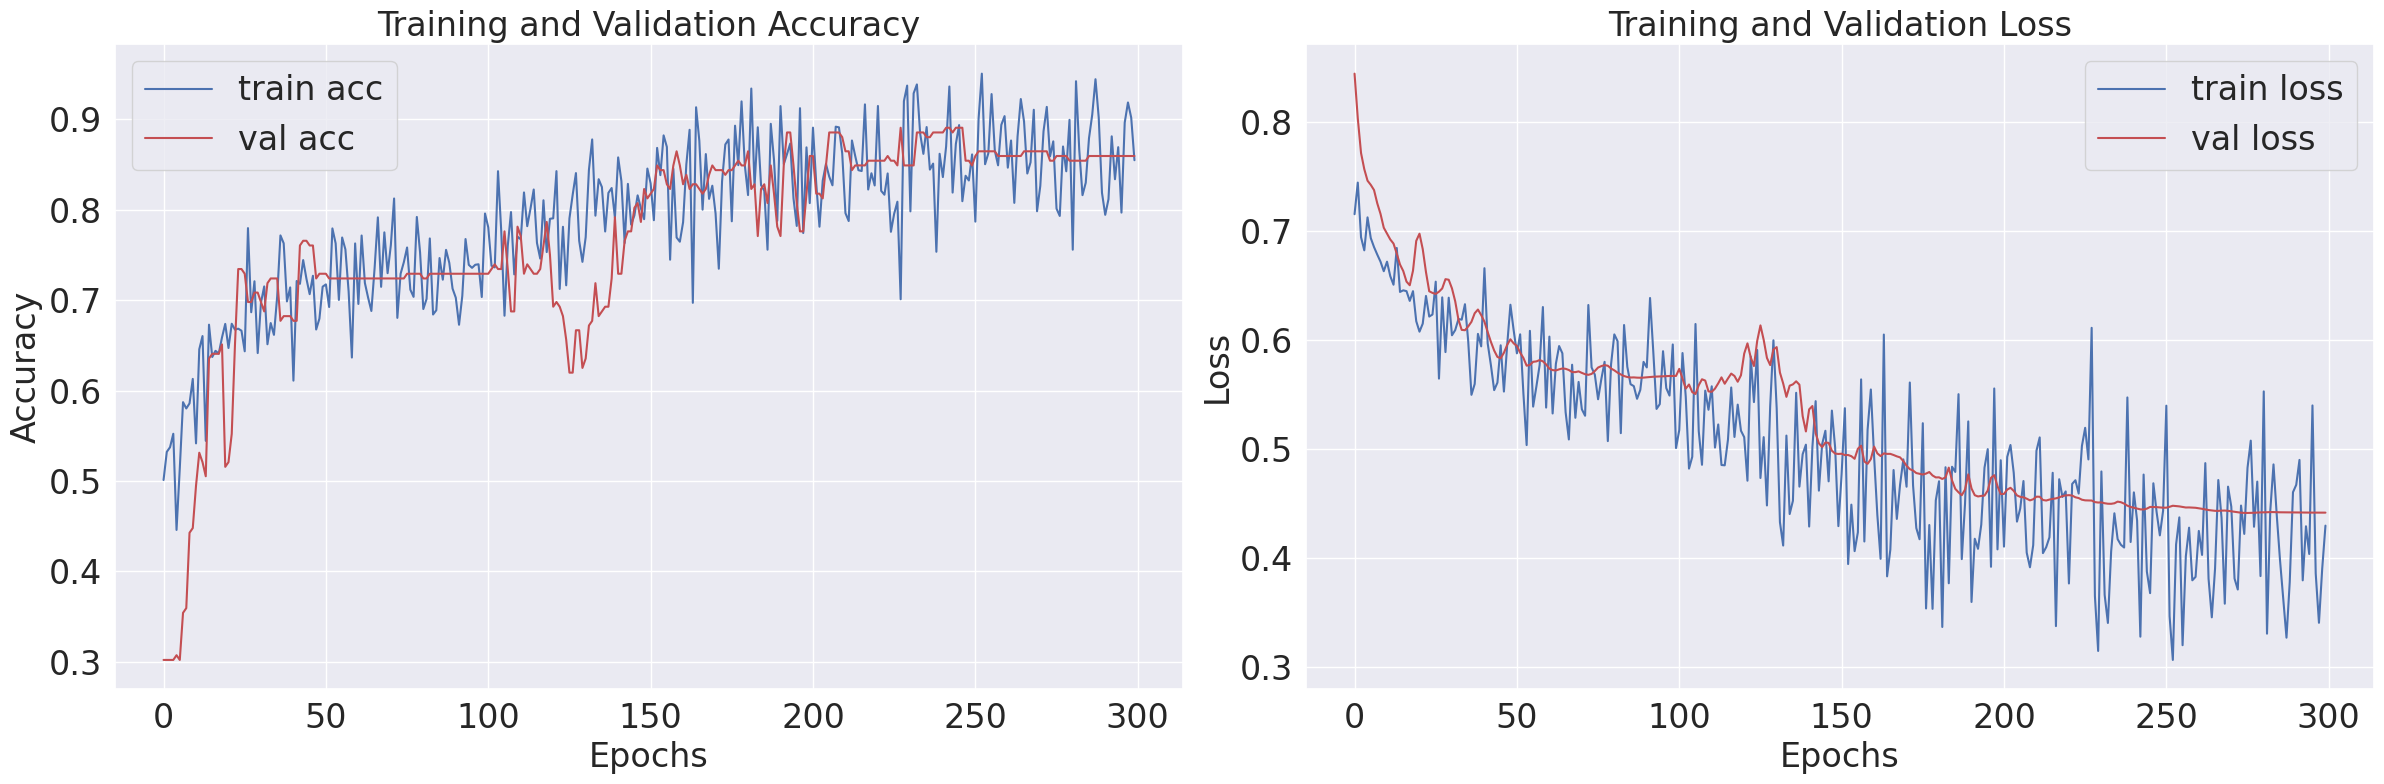

In [22]:
#出力したテンソルのデバイスをCPUへ切り替える
# GoogleColabの場合は不要
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 仮にepochsの数をトレーニングデータの長さから取得する
epochs = len(train_acc_list)  # train_acc_listの長さを使用

train_acc = []
train_loss = []
val_acc = []
val_loss = []

# 各リストをnumpy配列に変換し、リストに追加
for i in range(epochs):
    train_acc.append(train_acc_list[i].detach().cpu().numpy())
    train_loss.append(train_loss_list[i].detach().cpu().numpy())
    val_acc.append(val_acc_list[i].detach().cpu().numpy())
    val_loss.append(val_loss_list[i].detach().cpu().numpy())

# グラフ化
sns.set()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

ax1.plot(range(epochs), train_acc, 'b', label='train acc')
ax1.plot(range(epochs), val_acc, 'r', label='val acc')
ax1.set_title('Training and Validation Accuracy',fontsize=24)
ax1.set_xlabel('Epochs',fontsize=24)
ax1.set_ylabel('Accuracy',fontsize=24)
ax1.legend(fontsize=24)
ax1.tick_params(labelsize=24)

ax2.plot(range(epochs), train_loss, 'b', label='train loss')
ax2.plot(range(epochs), val_loss, 'r', label='val loss')
ax2.set_title('Training and Validation Loss',fontsize=24)
ax2.tick_params(labelsize=24)
ax2.set_xlabel('Epochs',fontsize=24)
ax2.set_ylabel('Loss',fontsize=24)
ax2.legend(fontsize=24)
ax2.tick_params(labelsize=24)
plt.tight_layout()
plt.show()


Extracting validation set logits...


Extracting logits: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


Extracting test set logits...


Extracting logits: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Calibrating model...

Validation Set Results:


Calculating confidence interval: 100%|██████████| 1000/1000 [00:01<00:00, 654.99it/s]


Calibrated ROC AUC: 0.9327 [95% CI: 0.8811-0.9697]

Test Set Results:


Calculating confidence interval: 100%|██████████| 1000/1000 [00:01<00:00, 684.19it/s]


Calibrated ROC AUC: 0.9396 [95% CI: 0.8551-0.9944]


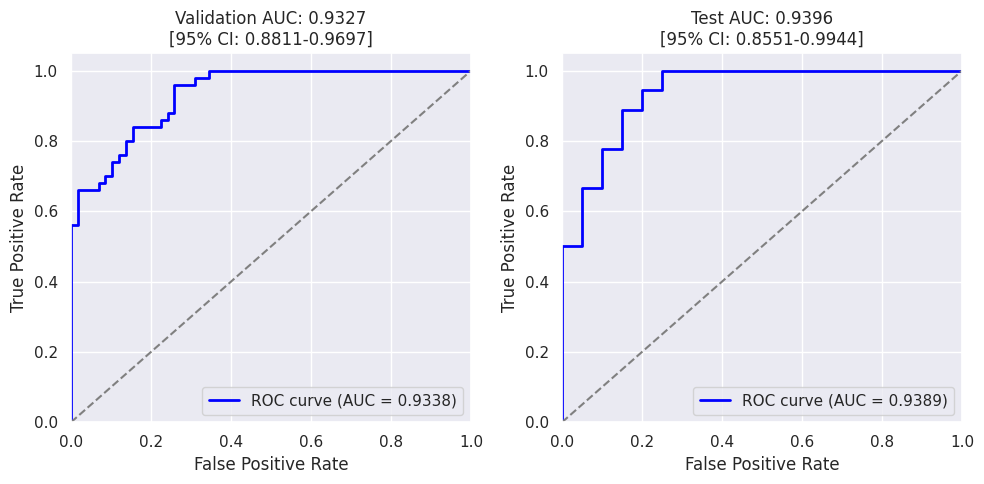

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from scipy import stats
import numpy as np
from tqdm import tqdm

def calculate_roc_auc_ci(y_true, y_pred, n_bootstraps=1000, confidence_level=0.95):
    """
    ROC-AUCスコアとその信頼区間を計算

    Args:
        y_true: 真のラベル
        y_pred: 予測確率
        n_bootstraps: ブートストラップの回数
        confidence_level: 信頼区間の水準

    Returns:
        auc_score: AUCスコア
        ci_lower: 信頼区間下限
        ci_upper: 信頼区間上限
    """
    bootstrapped_scores = []
    rng = np.random.RandomState(42)

    for i in tqdm(range(n_bootstraps), desc="Calculating confidence interval"):
        # ブートストラップサンプルのインデックスを生成
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            # Skip if the bootstrap sample contains only one class
            continue

        # 各ブートストラップサンプルでAUCを計算
        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)

    # 信頼区間の計算
    alpha = (1 - confidence_level)
    ci_lower = np.percentile(bootstrapped_scores, alpha/2 * 100)
    ci_upper = np.percentile(bootstrapped_scores, (1 - alpha/2) * 100)

    return np.mean(bootstrapped_scores), ci_lower, ci_upper

def extract_logits(model, loader, device):
    """モデルからロジットを抽出"""
    model.eval()
    logits = []
    targets = []
    with torch.no_grad():
        for data, target in tqdm(loader, desc="Extracting logits"):
            data, target = data.to(device), target.to(device)
            output = model(data)
            logits.extend(output.cpu().numpy())
            targets.extend(target.cpu().numpy())
    return np.array(logits), np.array(targets)

def calibrate_and_evaluate(model, valid_loader, test_loader, device):
    """モデルのキャリブレーションと評価を実行"""
    print("Extracting validation set logits...")
    val_logits, val_targets = extract_logits(model, valid_loader, device)

    print("Extracting test set logits...")
    test_logits, test_targets = extract_logits(model, test_loader, device)

    # プラットスケーリングの設定
    print("Calibrating model...")
    calibrator = LogisticRegression(solver='liblinear', max_iter=1000)
    calibrated_model = CalibratedClassifierCV(calibrator, method='sigmoid', cv='prefit')

    # キャリブレーションの実行
    calibrator.fit(val_logits, val_targets)
    calibrated_model.fit(val_logits, val_targets)

    # 予測確率の取得
    val_probs = calibrated_model.predict_proba(val_logits)[:, 1]
    test_probs = calibrated_model.predict_proba(test_logits)[:, 1]

    # 検証セットの評価
    print("\nValidation Set Results:")
    val_auc, val_ci_lower, val_ci_upper = calculate_roc_auc_ci(val_targets, val_probs)
    print(f"Calibrated ROC AUC: {val_auc:.4f} [95% CI: {val_ci_lower:.4f}-{val_ci_upper:.4f}]")

    # テストセットの評価
    print("\nTest Set Results:")
    test_auc, test_ci_lower, test_ci_upper = calculate_roc_auc_ci(test_targets, test_probs)
    print(f"Calibrated ROC AUC: {test_auc:.4f} [95% CI: {test_ci_lower:.4f}-{test_ci_upper:.4f}]")

    # ROC曲線のプロット
    plt.figure(figsize=(10, 5))

    # 検証セットのROC曲線
    plt.subplot(1, 2, 1)
    plot_roc_curve(val_targets, val_probs, "Validation Set ROC")
    plt.title(f"Validation AUC: {val_auc:.4f}\n[95% CI: {val_ci_lower:.4f}-{val_ci_upper:.4f}]")

    # テストセットのROC曲線
    plt.subplot(1, 2, 2)
    plot_roc_curve(test_targets, test_probs, "Test Set ROC")
    plt.title(f"Test AUC: {test_auc:.4f}\n[95% CI: {test_ci_lower:.4f}-{test_ci_upper:.4f}]")

    plt.tight_layout()
    plt.show()

    # モデルを更新
    model.calibrator = calibrated_model

    return {
        'validation': {
            'auc': val_auc,
            'ci_lower': val_ci_lower,
            'ci_upper': val_ci_upper,
            'predictions': val_probs
        },
        'test': {
            'auc': test_auc,
            'ci_lower': test_ci_lower,
            'ci_upper': test_ci_upper,
            'predictions': test_probs
        }
    }

def plot_roc_curve(y_true, y_pred_proba, title):
    """ROC曲線をプロット"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_score = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)

# 使用例
results = calibrate_and_evaluate(model, valid_loader, test_loader, device)

In [25]:
model_save_path = '/content/drive/MyDrive/swin_transformer_with_mixup_checkpoint3'
torch.save(model.state_dict(), model_save_path)

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

def extract_logits(model, loader, device):
    model.eval()
    logits = []
    targets = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            logits.extend(output.cpu().numpy())
            targets.extend(target.cpu().numpy())
    return np.array(logits), np.array(targets)

# ロジットとターゲットを抽出
val_logits, val_targets = extract_logits(model, valid_loader, device)

# プラットスケーリングを使用してモデルをカリブレーション
calibrator = LogisticRegression(solver='liblinear', max_iter=1000)
calibrated_model = CalibratedClassifierCV(calibrator, method='sigmoid', cv='prefit')

# 検証セットのロジットとターゲットを使って、ベースのcalibratorをフィッティング
calibrator.fit(val_logits, val_targets)
# 検証セットの確率を使ってフィッティング
calibrated_model.fit(val_logits, val_targets)

# カリブレーション後の確率を評価
calibrated_probs = calibrated_model.predict_proba(val_logits)[:, 1]

# パフォーマンス評価
roc_auc = roc_auc_score(val_targets, calibrated_probs)
print(f"Calibrated ROC AUC: {roc_auc:.4f}")

# 保存や他の用途で使用するためにモデルを更新
model.calibrator = calibrated_model

Calibrated ROC AUC: 0.9338


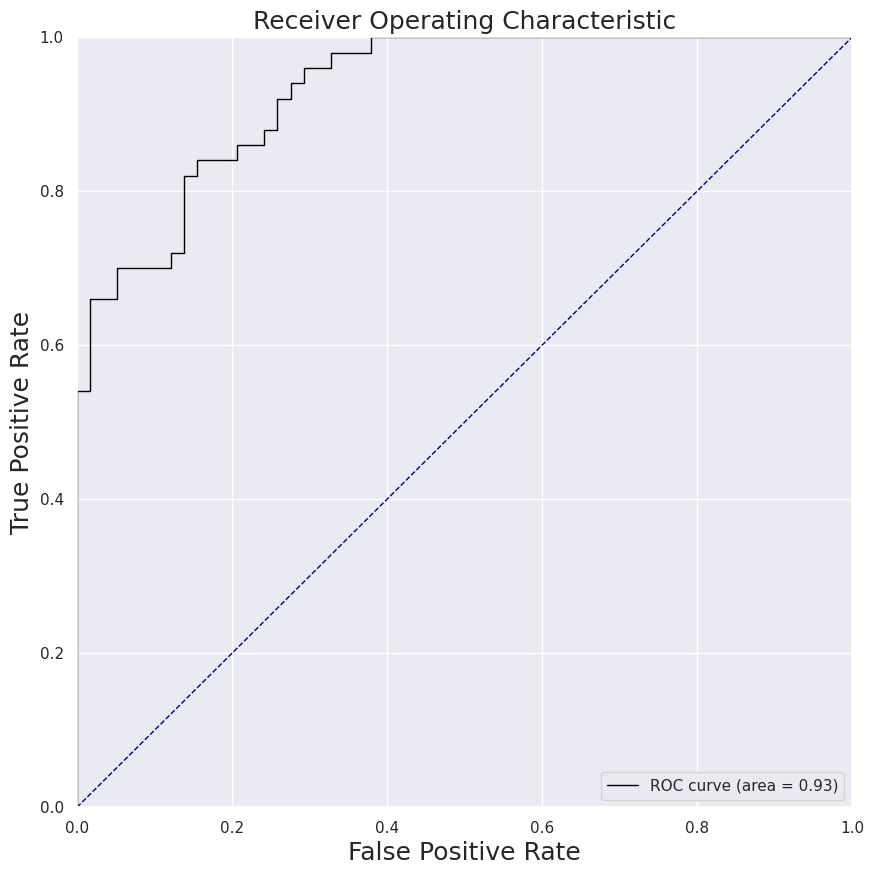

In [27]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(model, loader, device):
    # 真のラベルと予測確率を収集
    true_labels = []
    pred_probs = []

    model.eval()
    with torch.no_grad():
        for data, labels in loader:
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data)
            # ソフトマックスを適用して確率を取得
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            pred_probs.extend(probabilities[:, 1].cpu().numpy())  # クラス1の確率を取得
            true_labels.extend(labels.cpu().numpy())

    # ROCカーブの計算
    fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
    roc_auc = auc(fpr, tpr)

    # ROCカーブの描画
    plt.figure(figsize=(10, 10))
    lw = 1
    plt.plot(fpr, tpr, color='black',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 2], [0, 2], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Receiver Operating Characteristic',fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

# 使用例: 有効データローダーとデバイス情報を指定してROC曲線を描画
plot_roc_curve(model, valid_loader, device)


In [28]:
import pickle
# カリブレーターの保存
with open('/content/drive/MyDrive/calibrated_model3.pkl', 'wb') as f:
    pickle.dump(calibrated_model, f)

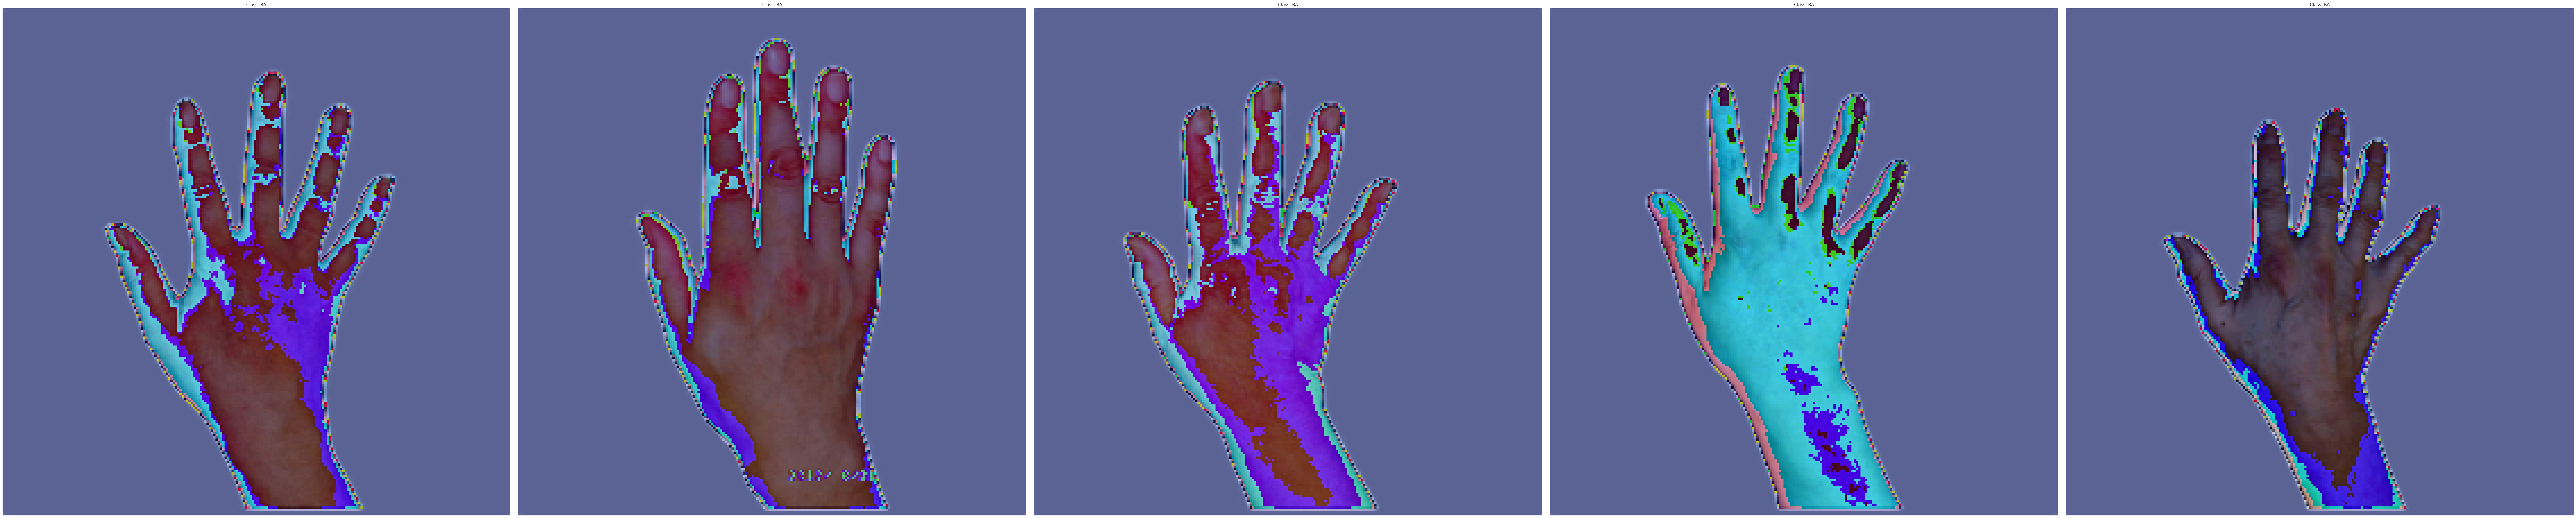

49523

In [29]:
class GradCam:
    def __init__(self, model, device):
        self.model = model
        self.feature = None
        self.gradient = None
        self.device = device

        def forward_hook(module, input, output):
            self.feature = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradient = grad_out[0].detach()

        # Swin Transformerの最後のブロックを取得
        if hasattr(model, 'layers'):
            target_layer = model.layers[-1].blocks[-1]
            target_layer.register_forward_hook(forward_hook)
            target_layer.register_full_backward_hook(backward_hook)
        else:
            raise ValueError("Unexpected model architecture")

    def __call__(self, x):
        self.feature = None
        self.gradient = None

        x = x.to(self.device)

        output = self.model(x)
        pred_class = output.argmax(dim=1)

        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, pred_class] = 1
        output.backward(gradient=one_hot)

        # Swin Transformerの特徴量マップの形状に合わせて処理
        feature_map = self.feature
        gradient_map = self.gradient

        # 重みの計算
        weights = gradient_map.mean(dim=(2, 3))  # Swinの場合、spatial dimensionsで平均を取る

        # CAMの計算
        batch_size = feature_map.shape[0]
        height = feature_map.shape[2]
        width = feature_map.shape[3]

        cam = torch.mul(feature_map, weights.view(batch_size, -1, 1, 1))
        cam = cam.sum(dim=1)  # チャネル方向に集約

        # 正規化とReLU
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()

        # 元の画像サイズにリサイズ
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-7)

        return cam

def overlay_heatmap_to_image(image, heatmap):
    image = ((image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) * 255).astype(np.uint8)

    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    alpha = 0.2
    overlayed = cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)

    return overlayed / 255.0

# 実行部分
grad_cam = GradCam(model, device)

images, labels = next(iter(test_loader))
images = images[:5]
labels = labels[:5]

plt.figure(figsize=(100, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    try:
        heatmap = grad_cam(image.unsqueeze(0))
        overlayed = overlay_heatmap_to_image(image, heatmap)

        plt.subplot(1, 5, i+1)
        plt.imshow(overlayed)
        plt.title(f'Class: {"RA" if label.item() == 0 else "Non-RA"}')
        plt.axis('off')
    except Exception as e:
        print(f"Error processing image {i}: {str(e)}")

plt.tight_layout()
plt.show()

torch.cuda.empty_cache()
gc.collect()

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import make_grid
import torch

# 1. 予測と確信度の取得
def get_predictions(model, val_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    confidences = []
    image_paths = []  # 画像のパスまたは画像自体を保存

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            conf, preds = torch.max(probs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            confidences.extend(conf.cpu().numpy())
            image_paths.extend(images.cpu())  # または元の画像パス

    return np.array(predictions), np.array(true_labels), np.array(confidences), image_paths

# 2. 混同行列の作成と可視化
def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# 3. 誤分類サンプルの分析
def analyze_misclassifications(true_labels, predictions, confidences, image_paths, class_names):
    # 誤分類のインデックスを取得
    misclassified_idx = np.where(predictions != true_labels)[0]

    # 確信度でソート
    sorted_idx = sorted(misclassified_idx,
                       key=lambda x: confidences[x],
                       reverse=True)

    # 上位の誤分類ケースを表示
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    for idx, ax in enumerate(axes):
        if idx < len(sorted_idx):
            mis_idx = sorted_idx[idx]
            image = image_paths[mis_idx]
            true_label = class_names[true_labels[mis_idx]]
            pred_label = class_names[predictions[mis_idx]]
            conf = confidences[mis_idx]

            ax.imshow(image.permute(1, 2, 0))
            ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# 4. 確信度分布の分析
def plot_confidence_distribution(confidences, predictions, true_labels):
    plt.figure(figsize=(10, 6))

    # 正解と不正解の確信度を分離
    correct = confidences[predictions == true_labels]
    incorrect = confidences[predictions != true_labels]

    plt.hist([correct, incorrect], label=['Correct', 'Incorrect'],
             bins=30, alpha=0.6, density=True)
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.title('Confidence Distribution for Correct vs Incorrect Predictions')
    plt.legend()
    plt.show()

# メイン実行部分
def analyze_errors(model, val_loader, class_names, device):
    # 予測の取得
    predictions, true_labels, confidences, image_paths = get_predictions(model, val_loader, device)

    # 1. 全体の性能メトリクス
    print("Overall Accuracy:", np.mean(predictions == true_labels))

    # 2. 混同行列の表示
    plot_confusion_matrix(true_labels, predictions, class_names)

    # 3. 誤分類サンプルの表示
    analyze_misclassifications(true_labels, predictions, confidences,
                             image_paths, class_names)

    # 4. 確信度分布の表示
    plot_confidence_distribution(confidences, predictions, true_labels)

    # 5. クラスごとの詳細な分析
    for i, class_name in enumerate(class_names):
        class_mask = true_labels == i
        class_acc = np.mean(predictions[class_mask] == true_labels[class_mask])
        print(f"\nClass {class_name}:")
        print(f"Accuracy: {class_acc:.3f}")
        print(f"Average confidence: {np.mean(confidences[class_mask]):.3f}")
        print(f"Samples: {np.sum(class_mask)}")

<ipython-input-31-3c2aafc37d31>:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/swin_transformer_with_mixup_check

Overall Accuracy: 0.815


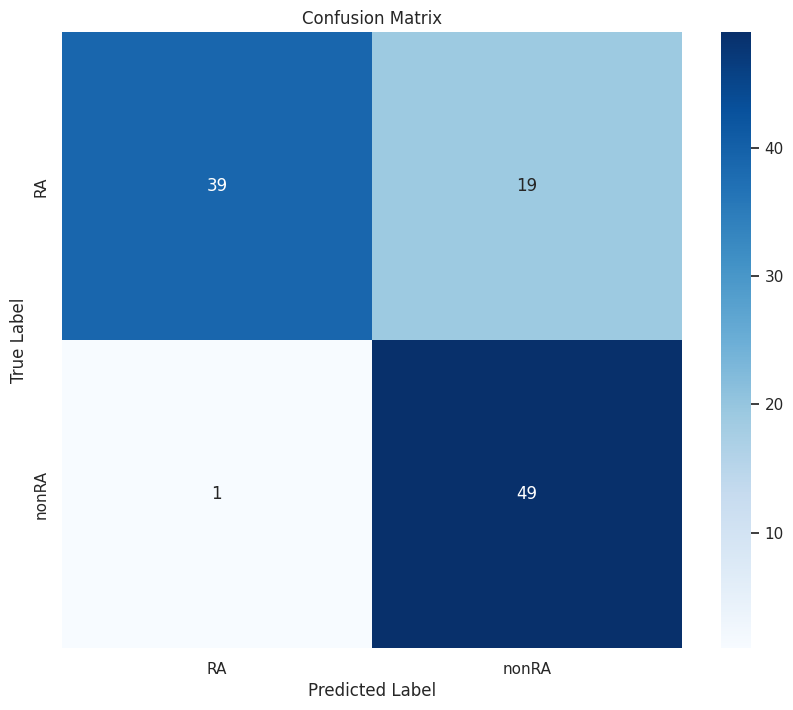

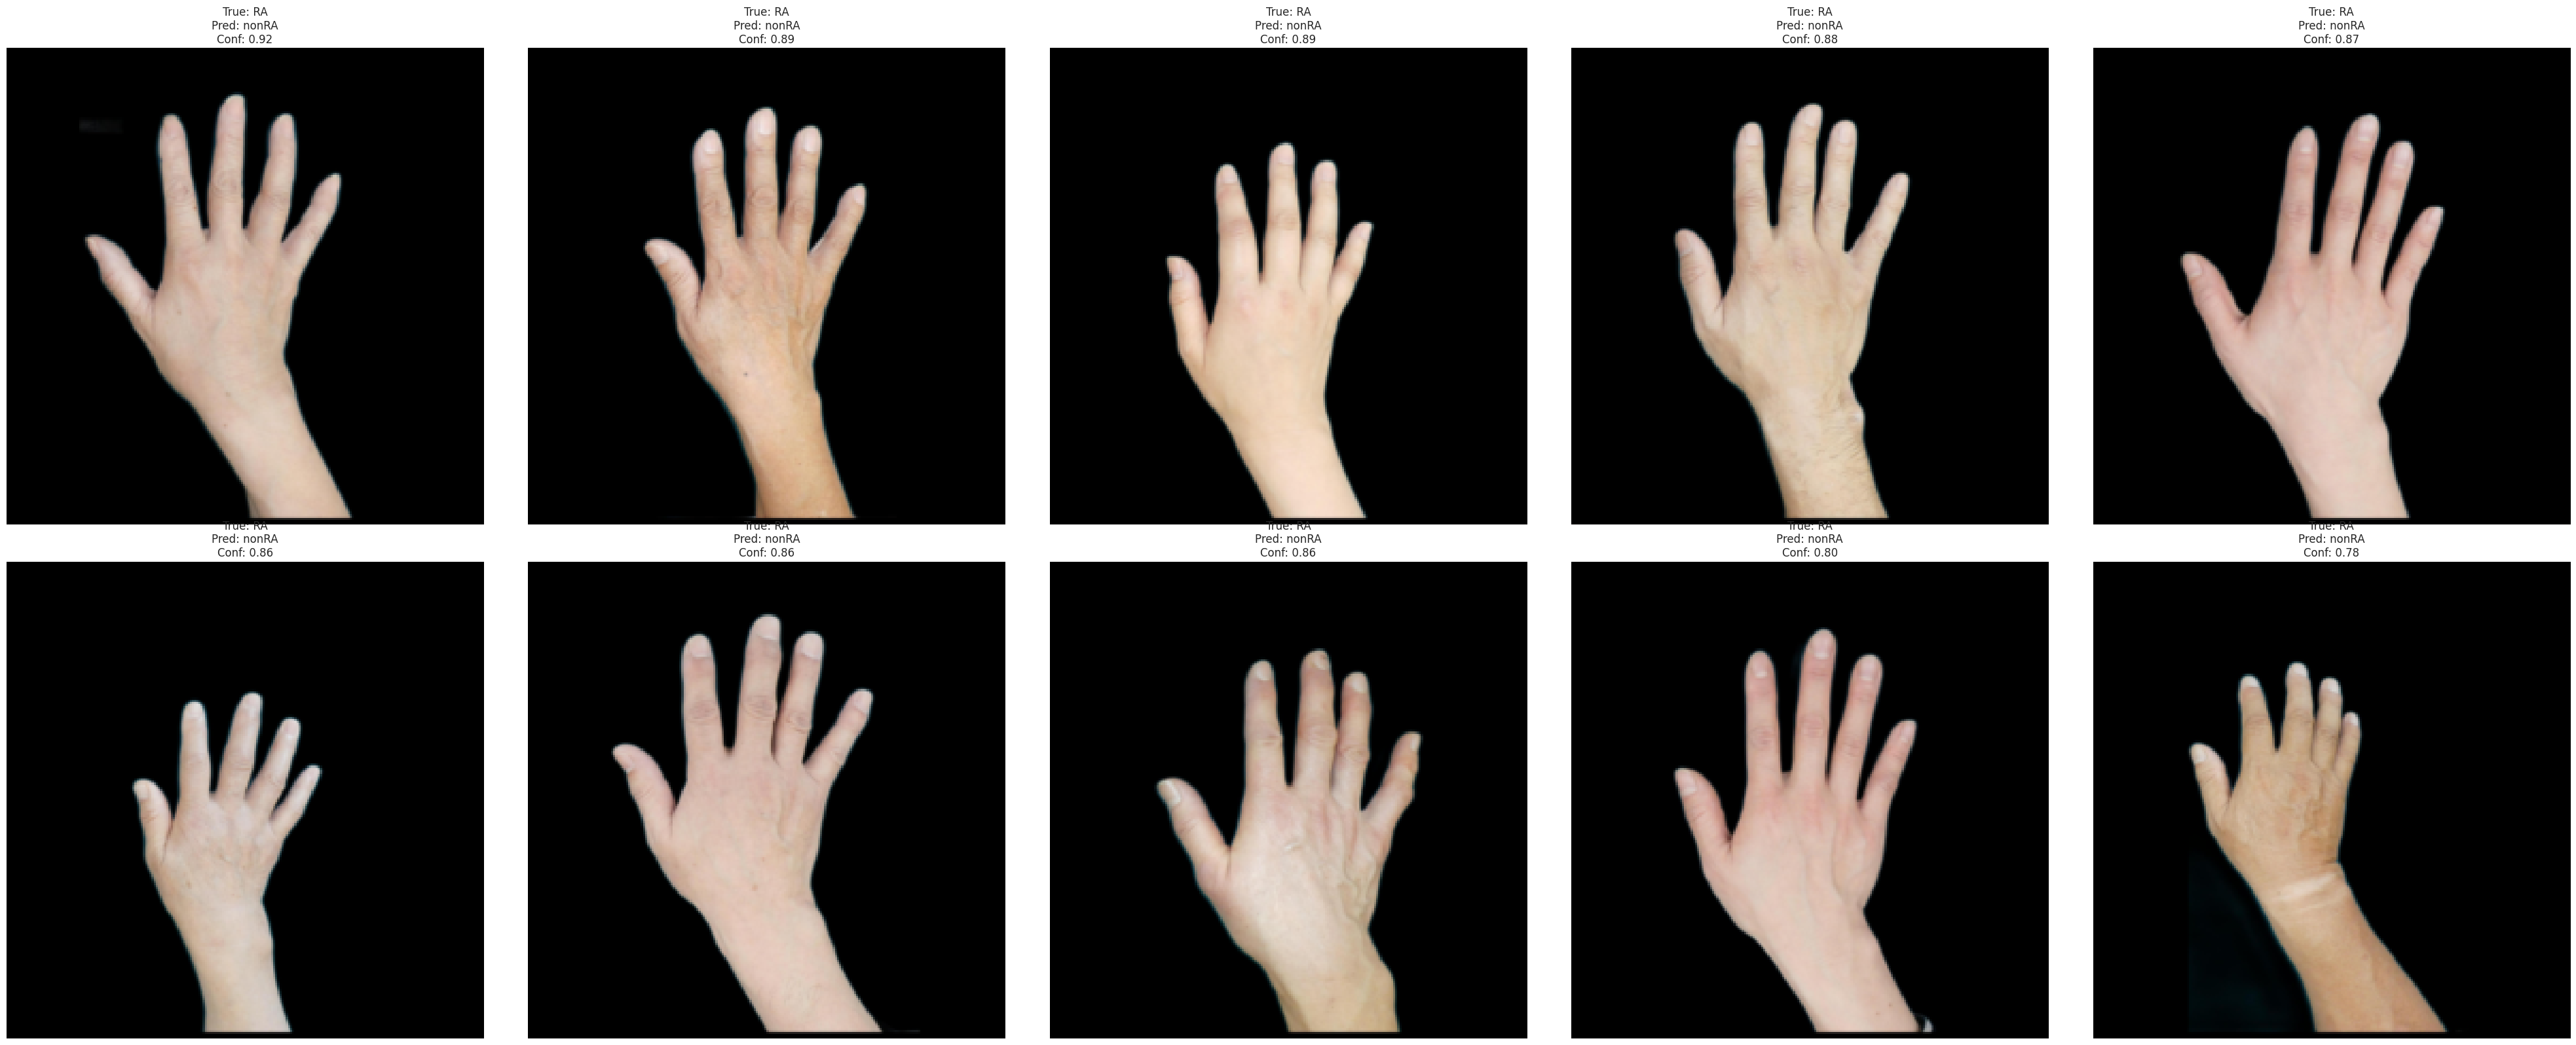

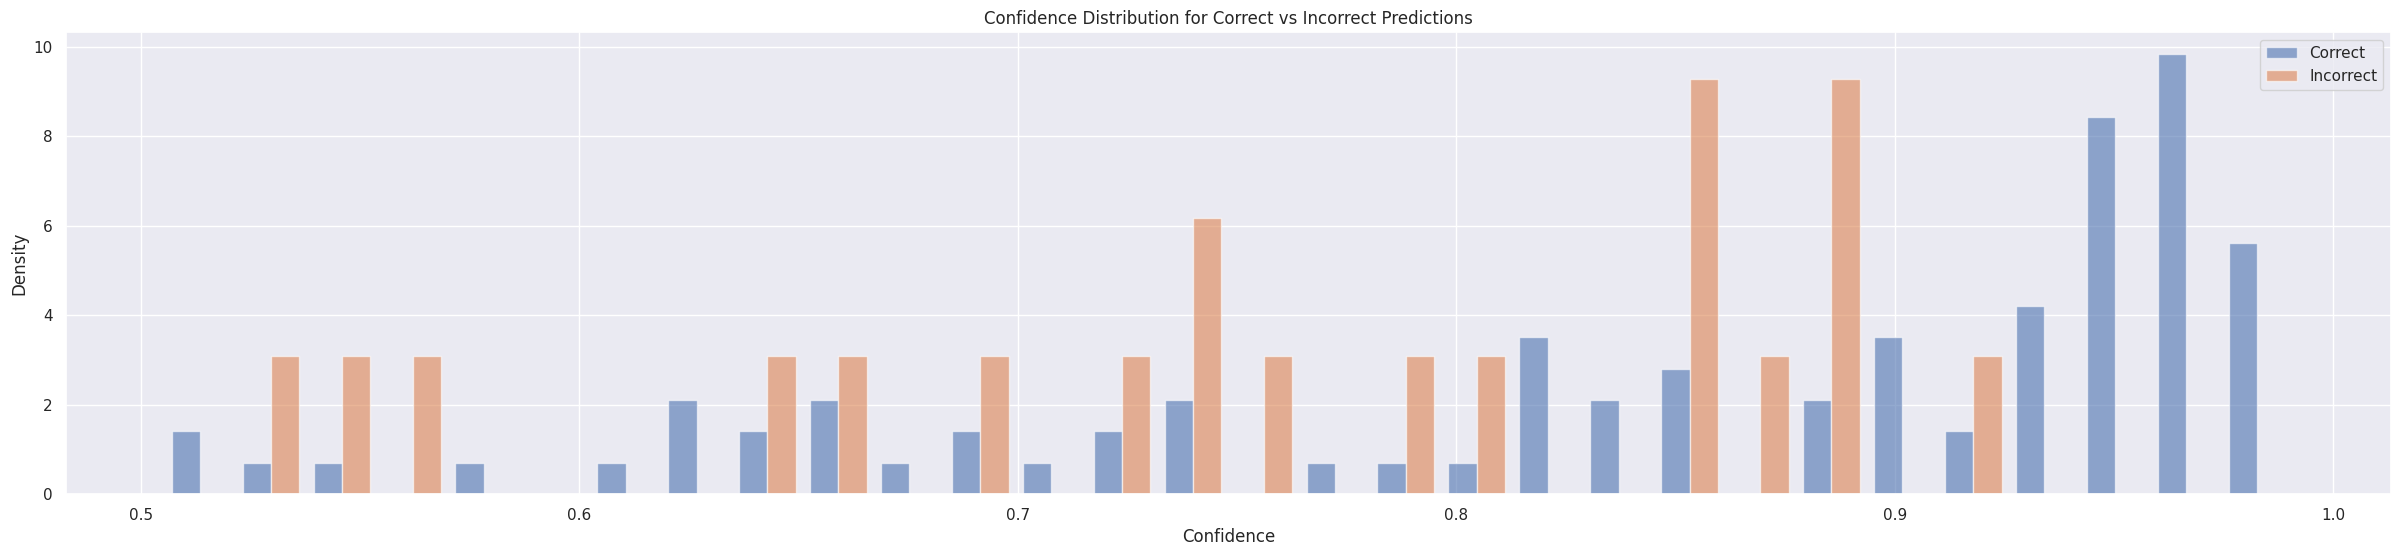


Class RA:
Accuracy: 0.672
Average confidence: 0.791
Samples: 58

Class nonRA:
Accuracy: 0.980
Average confidence: 0.879
Samples: 50


In [31]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import make_grid
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

def get_predictions(model, val_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    confidences = []
    images_list = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            conf, preds = torch.max(probs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            confidences.extend(conf.cpu().numpy())
            images_list.extend(images.cpu())

    return np.array(predictions), np.array(true_labels), np.array(confidences), images_list

def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def analyze_misclassifications(true_labels, predictions, confidences, images_list, class_names):
    misclassified_idx = np.where(predictions != true_labels)[0]

    if len(misclassified_idx) == 0:
        print("No misclassified samples found!")
        return

    sorted_idx = sorted(misclassified_idx,
                       key=lambda x: confidences[x],
                       reverse=True)

    n_samples = min(10, len(sorted_idx))
    fig, axes = plt.subplots(2, 5, figsize=(40, 16))
    axes = axes.ravel()

    for idx, ax in enumerate(axes):
        if idx < n_samples:
            mis_idx = sorted_idx[idx]
            image = images_list[mis_idx]
            true_label = class_names[true_labels[mis_idx]]
            pred_label = class_names[predictions[mis_idx]]
            conf = confidences[mis_idx]

            # 画像の正規化を元に戻す（必要に応じて調整）
            image = image.permute(1, 2, 0)
            image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
            image = torch.clamp(image, 0, 1)

            ax.imshow(image)
            ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

def plot_confidence_distribution(confidences, predictions, true_labels):
    plt.figure(figsize=(30, 6))

    correct = confidences[predictions == true_labels]
    incorrect = confidences[predictions != true_labels]

    plt.hist([correct, incorrect], label=['Correct', 'Incorrect'],
             bins=30, alpha=0.6, density=True)
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.title('Confidence Distribution for Correct vs Incorrect Predictions')
    plt.legend()
    plt.show()

# メインの実行コード
def main():
    # デバイスの設定
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # クラス名の設定（あなたのデータセットに合わせて修正）
    class_names = ['RA', 'nonRA']  # あなたのクラス名に置き換えてください

    model = timm.create_model(
        'swin_base_patch4_window7_224.ms_in1k',
        pretrained=False,
        num_classes=2,
    )

    # モデルの読み込み（あなたの保存したモデルのパスに修正）
    model.load_state_dict(torch.load('/content/drive/MyDrive/swin_transformer_with_mixup_checkpoint3'))
    model = model.to(device)

    # 予測の実行
    predictions, true_labels, confidences, images_list = get_predictions(model, val_loader, device)

    # 全体の性能メトリクス
    accuracy = np.mean(predictions == true_labels)
    print(f"Overall Accuracy: {accuracy:.3f}")

    # 混同行列の表示
    plot_confusion_matrix(true_labels, predictions, class_names)

    # 誤分類サンプルの表示
    analyze_misclassifications(true_labels, predictions, confidences, images_list, class_names)

    # 確信度分布の表示
    plot_confidence_distribution(confidences, predictions, true_labels)

    # クラスごとの詳細な分析
    for i, class_name in enumerate(class_names):
        class_mask = true_labels == i
        class_acc = np.mean(predictions[class_mask] == true_labels[class_mask])
        print(f"\nClass {class_name}:")
        print(f"Accuracy: {class_acc:.3f}")
        print(f"Average confidence: {np.mean(confidences[class_mask]):.3f}")
        print(f"Samples: {np.sum(class_mask)}")

if __name__ == '__main__':
    val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)  # あなたの検証用DataLoaderを設定

    main()